# Train Log 20181201

* Add multi-model training structure

## Results
```

```

## Trained model
* [Download link]()

## Evaluation
* Incorrect sample
![results]()

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import time , datetime

sys.path.append( os.path.abspath('../../../Dataset/scripts'))
from utils import *

sys.path.append( os.path.abspath('../../model') )
from train import *

import multiprocessing

import tensorflow as tf


In [2]:
""" Path """
data_train_path = os.path.abspath('../../../Dataset_ver2/dataset/db_v8_aug_20181129_ndb_v2_20181020/train.h5')
data_vali_path = os.path.abspath('../../../Dataset_ver2/dataset/db_v8_aug_20181129_ndb_v2_20181020/vali.h5')


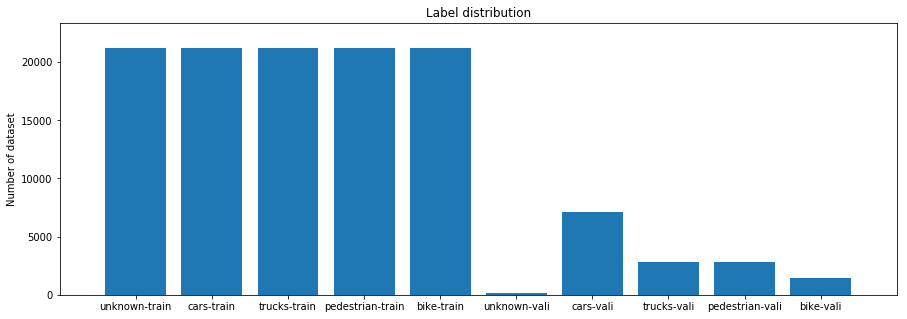

In [3]:
""" Load dataset"""

data = []
label = []

data_train, label_train = load_h5(data_train_path)
data_vali, label_vali = load_h5(data_vali_path)

data.append(data_train)
data.append(data_vali)
label.append(label_train)
label.append(label_vali)

""" Data statistics """

label_list = [0,1,2,3,4]

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(label[i] == label_list[j]))

x_name=('unknown-train', 'cars-train', 'trucks-train', 'pedestrian-train', 'bike-train',
        'unknown-vali', 'cars-vali', 'trucks-vali', 'pedestrian-vali', 'bike-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [4]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_out_5 as MODEL

def run_training(out_path):
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 5

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 10

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)

            # Get model and loss 
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, labels_pl, end_points)
            tf.summary.scalar('loss', loss)

            correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            # Get training operator
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        # Add summary writers
        #merged = tf.merge_all_summaries()
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)


        # Init variables
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            # Shuffle train files
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_label = label_train[train_file_idxs]
            current_label.reshape((data_train.shape[0],))

            ## Evaluation metric
            total_correct = 0
            total_seen = 0
            loss_sum = 0

            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            ## Evaluation using validation set    
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False
            total_correct = 0
            total_seen = 0
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]

            # Shuffle validation files
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_label = label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training}
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                # test_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE

                for i in range(NUM_CLASSES):
                    total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] vali mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            # Save the variables to disk.
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_out5',))
p.start()
p.join()

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-01 14:02:18.560566   Train one epoch   1 /  10


100%|██████████| 2124/2124 [12:38<00:00,  2.80it/s]


2018-12-01 14:14:58.678178  [Epoch 0] mean loss: 0.012596
2018-12-01 14:14:58.680110  [Epoch 0] accuracy: 0.751629
2018-12-01 14:14:58.682081  [Epoch 0] avg class acc: 0.751629
2018-12-01 14:14:58.683756  [Epoch 0] indivisual [0] class recall: 0.954284
2018-12-01 14:14:58.685437  [Epoch 0] indivisual [0] class precision: 0.955364
2018-12-01 14:14:58.687071  [Epoch 0] indivisual [1] class recall: 0.716290
2018-12-01 14:14:58.689079  [Epoch 0] indivisual [1] class precision: 0.664280
2018-12-01 14:14:58.691188  [Epoch 0] indivisual [2] class recall: 0.620198
2018-12-01 14:14:58.692989  [Epoch 0] indivisual [2] class precision: 0.695916
2018-12-01 14:14:58.694659  [Epoch 0] indivisual [3] class recall: 0.723352
2018-12-01 14:14:58.696369  [Epoch 0] indivisual [3] class precision: 0.694261
2018-12-01 14:14:58.698106  [Epoch 0] indivisual [4] class recall: 0.744021
2018-12-01 14:14:58.699739  [Epoch 0] indivisual [4] class precision: 0.751736
2018-12-01 14:14:58.701464   Evaluation one (val

100%|██████████| 287/287 [00:24<00:00, 11.78it/s]


2018-12-01 14:15:23.358130  [Epoch 0] vali mean loss: 0.093221
2018-12-01 14:15:23.360027  [Epoch 0] vali accuracy: 0.973589
2018-12-01 14:15:23.362043  [Epoch 0] vali avg class acc: 0.600000
2018-12-01 14:15:23.363667  [Epoch 0] vali indivisual [1] class recall: 1.000000
2018-12-01 14:15:23.365400  [Epoch 0] vali indivisual [1] class precision: 0.960000
2018-12-01 14:15:23.367037  [Epoch 0] vali indivisual [2] class recall: 0.888889
2018-12-01 14:15:23.368752  [Epoch 0] vali indivisual [2] class precision: 1.000000
2018-12-01 14:15:23.370359  [Epoch 0] vali indivisual [3] class recall: 1.000000
2018-12-01 14:15:23.372145  [Epoch 0] vali indivisual [3] class precision: 1.000000
2018-12-01 14:15:23.373690  [Epoch 0] vali indivisual [4] class recall: 1.000000
2018-12-01 14:15:23.375358  [Epoch 0] vali indivisual [4] class precision: 1.000000
2018-12-01 14:15:23.377268   Train one epoch   2 /  10


100%|██████████| 2124/2124 [12:37<00:00,  2.80it/s]


2018-12-01 14:28:02.108423  [Epoch 1] mean loss: 0.002450
2018-12-01 14:28:02.110575  [Epoch 1] accuracy: 0.960075
2018-12-01 14:28:02.112622  [Epoch 1] avg class acc: 0.960075
2018-12-01 14:28:02.114317  [Epoch 1] indivisual [0] class recall: 0.993409
2018-12-01 14:28:02.116105  [Epoch 1] indivisual [0] class precision: 0.989449
2018-12-01 14:28:02.117727  [Epoch 1] indivisual [1] class recall: 0.952260
2018-12-01 14:28:02.119318  [Epoch 1] indivisual [1] class precision: 0.946910
2018-12-01 14:28:02.120912  [Epoch 1] indivisual [2] class recall: 0.961252
2018-12-01 14:28:02.122546  [Epoch 1] indivisual [2] class precision: 0.955628
2018-12-01 14:28:02.124191  [Epoch 1] indivisual [3] class recall: 0.959228
2018-12-01 14:28:02.125864  [Epoch 1] indivisual [3] class precision: 0.961673
2018-12-01 14:28:02.127329  [Epoch 1] indivisual [4] class recall: 0.934228
2018-12-01 14:28:02.129053  [Epoch 1] indivisual [4] class precision: 0.946527
2018-12-01 14:28:02.130983   Evaluation one (val

100%|██████████| 287/287 [00:23<00:00, 12.10it/s]


2018-12-01 14:28:26.129648  [Epoch 1] vali mean loss: 0.018133
2018-12-01 14:28:26.131480  [Epoch 1] vali accuracy: 0.989338
2018-12-01 14:28:26.133272  [Epoch 1] vali avg class acc: 0.800000
2018-12-01 14:28:26.134875  [Epoch 1] vali indivisual [0] class recall: 1.000000
2018-12-01 14:28:26.136610  [Epoch 1] vali indivisual [0] class precision: 1.000000
2018-12-01 14:28:26.138183  [Epoch 1] vali indivisual [1] class recall: 0.958333
2018-12-01 14:28:26.139677  [Epoch 1] vali indivisual [1] class precision: 1.000000
2018-12-01 14:28:26.141592  [Epoch 1] vali indivisual [2] class recall: 1.000000
2018-12-01 14:28:26.143668  [Epoch 1] vali indivisual [2] class precision: 1.000000
2018-12-01 14:28:26.145370  [Epoch 1] vali indivisual [3] class recall: 1.000000
2018-12-01 14:28:26.147014  [Epoch 1] vali indivisual [3] class precision: 1.000000
2018-12-01 14:28:26.148836  [Epoch 1] vali indivisual [4] class recall: 1.000000
2018-12-01 14:28:26.150582  [Epoch 1] vali indivisual [4] class pre

100%|██████████| 2124/2124 [12:37<00:00,  2.80it/s]


2018-12-01 14:41:04.968216  [Epoch 2] mean loss: 0.000737
2018-12-01 14:41:04.970225  [Epoch 2] accuracy: 0.988578
2018-12-01 14:41:04.972263  [Epoch 2] avg class acc: 0.988578
2018-12-01 14:41:04.974174  [Epoch 2] indivisual [0] class recall: 0.998399
2018-12-01 14:41:04.976114  [Epoch 2] indivisual [0] class precision: 0.997319
2018-12-01 14:41:04.977993  [Epoch 2] indivisual [1] class recall: 0.985452
2018-12-01 14:41:04.979666  [Epoch 2] indivisual [1] class precision: 0.985081
2018-12-01 14:41:04.981360  [Epoch 2] indivisual [2] class recall: 0.988465
2018-12-01 14:41:04.982935  [Epoch 2] indivisual [2] class precision: 0.986978
2018-12-01 14:41:04.984647  [Epoch 2] indivisual [3] class recall: 0.989501
2018-12-01 14:41:04.986370  [Epoch 2] indivisual [3] class precision: 0.989501
2018-12-01 14:41:04.987944  [Epoch 2] indivisual [4] class recall: 0.981073
2018-12-01 14:41:04.989664  [Epoch 2] indivisual [4] class precision: 0.983992
2018-12-01 14:41:04.991221   Evaluation one (val

100%|██████████| 287/287 [00:23<00:00, 12.02it/s]


2018-12-01 14:41:29.135827  [Epoch 2] vali mean loss: 0.005455
2018-12-01 14:41:29.137777  [Epoch 2] vali accuracy: 0.995889
2018-12-01 14:41:29.141310  [Epoch 2] vali avg class acc: 1.000000
2018-12-01 14:41:29.143119  [Epoch 2] vali indivisual [0] class recall: 1.000000
2018-12-01 14:41:29.144914  [Epoch 2] vali indivisual [0] class precision: 1.000000
2018-12-01 14:41:29.146510  [Epoch 2] vali indivisual [1] class recall: 1.000000
2018-12-01 14:41:29.148068  [Epoch 2] vali indivisual [1] class precision: 1.000000
2018-12-01 14:41:29.149923  [Epoch 2] vali indivisual [2] class recall: 1.000000
2018-12-01 14:41:29.151780  [Epoch 2] vali indivisual [2] class precision: 1.000000
2018-12-01 14:41:29.153449  [Epoch 2] vali indivisual [3] class recall: 1.000000
2018-12-01 14:41:29.155038  [Epoch 2] vali indivisual [3] class precision: 1.000000
2018-12-01 14:41:29.156782  [Epoch 2] vali indivisual [4] class recall: 1.000000
2018-12-01 14:41:29.158348  [Epoch 2] vali indivisual [4] class pre

100%|██████████| 2124/2124 [12:37<00:00,  2.80it/s]


2018-12-01 14:54:07.712078  [Epoch 3] mean loss: 0.000563
2018-12-01 14:54:07.713982  [Epoch 3] accuracy: 0.991394
2018-12-01 14:54:07.715961  [Epoch 3] avg class acc: 0.991394
2018-12-01 14:54:07.717738  [Epoch 3] indivisual [0] class recall: 0.998493
2018-12-01 14:54:07.719387  [Epoch 3] indivisual [0] class precision: 0.998305
2018-12-01 14:54:07.721418  [Epoch 3] indivisual [1] class recall: 0.987853
2018-12-01 14:54:07.723314  [Epoch 3] indivisual [1] class precision: 0.988225
2018-12-01 14:54:07.725146  [Epoch 3] indivisual [2] class recall: 0.991149
2018-12-01 14:54:07.726865  [Epoch 3] indivisual [2] class precision: 0.989565
2018-12-01 14:54:07.728673  [Epoch 3] indivisual [3] class recall: 0.992467
2018-12-01 14:54:07.730382  [Epoch 3] indivisual [3] class precision: 0.993215
2018-12-01 14:54:07.732053  [Epoch 3] indivisual [4] class recall: 0.987006
2018-12-01 14:54:07.733718  [Epoch 3] indivisual [4] class precision: 0.987657
2018-12-01 14:54:07.735371   Evaluation one (val

100%|██████████| 287/287 [00:23<00:00, 12.02it/s]


2018-12-01 14:54:31.881824  [Epoch 3] vali mean loss: 0.004165
2018-12-01 14:54:31.883779  [Epoch 3] vali accuracy: 0.998955
2018-12-01 14:54:31.886859  [Epoch 3] vali avg class acc: 1.000000
2018-12-01 14:54:31.888678  [Epoch 3] vali indivisual [0] class recall: 1.000000
2018-12-01 14:54:31.890551  [Epoch 3] vali indivisual [0] class precision: 1.000000
2018-12-01 14:54:31.892539  [Epoch 3] vali indivisual [1] class recall: 1.000000
2018-12-01 14:54:31.894311  [Epoch 3] vali indivisual [1] class precision: 1.000000
2018-12-01 14:54:31.896017  [Epoch 3] vali indivisual [2] class recall: 1.000000
2018-12-01 14:54:31.897674  [Epoch 3] vali indivisual [2] class precision: 1.000000
2018-12-01 14:54:31.900256  [Epoch 3] vali indivisual [3] class recall: 1.000000
2018-12-01 14:54:31.902008  [Epoch 3] vali indivisual [3] class precision: 1.000000
2018-12-01 14:54:31.903638  [Epoch 3] vali indivisual [4] class recall: 1.000000
2018-12-01 14:54:31.905289  [Epoch 3] vali indivisual [4] class pre

100%|██████████| 2124/2124 [12:34<00:00,  2.81it/s]


2018-12-01 15:07:07.988352  [Epoch 4] mean loss: 0.000430
2018-12-01 15:07:07.990325  [Epoch 4] accuracy: 0.994623
2018-12-01 15:07:07.992285  [Epoch 4] avg class acc: 0.994623
2018-12-01 15:07:07.994037  [Epoch 4] indivisual [0] class recall: 0.998917
2018-12-01 15:07:07.995794  [Epoch 4] indivisual [0] class precision: 0.998118
2018-12-01 15:07:07.997602  [Epoch 4] indivisual [1] class recall: 0.992279
2018-12-01 15:07:07.999602  [Epoch 4] indivisual [1] class precision: 0.992279
2018-12-01 15:07:08.001713  [Epoch 4] indivisual [2] class recall: 0.993644
2018-12-01 15:07:08.003410  [Epoch 4] indivisual [2] class precision: 0.993083
2018-12-01 15:07:08.005090  [Epoch 4] indivisual [3] class recall: 0.995998
2018-12-01 15:07:08.006767  [Epoch 4] indivisual [3] class precision: 0.996186
2018-12-01 15:07:08.008495  [Epoch 4] indivisual [4] class recall: 0.992279
2018-12-01 15:07:08.010180  [Epoch 4] indivisual [4] class precision: 0.993448
2018-12-01 15:07:08.011793   Evaluation one (val

100%|██████████| 287/287 [00:23<00:00, 12.05it/s]


2018-12-01 15:07:32.141995  [Epoch 4] vali mean loss: 0.003184
2018-12-01 15:07:32.144017  [Epoch 4] vali accuracy: 0.999164
2018-12-01 15:07:32.146025  [Epoch 4] vali avg class acc: 1.000000
2018-12-01 15:07:32.147720  [Epoch 4] vali indivisual [0] class recall: 1.000000
2018-12-01 15:07:32.149355  [Epoch 4] vali indivisual [0] class precision: 1.000000
2018-12-01 15:07:32.151200  [Epoch 4] vali indivisual [1] class recall: 1.000000
2018-12-01 15:07:32.153099  [Epoch 4] vali indivisual [1] class precision: 1.000000
2018-12-01 15:07:32.154844  [Epoch 4] vali indivisual [2] class recall: 1.000000
2018-12-01 15:07:32.156574  [Epoch 4] vali indivisual [2] class precision: 1.000000
2018-12-01 15:07:32.158238  [Epoch 4] vali indivisual [3] class recall: 1.000000
2018-12-01 15:07:32.159919  [Epoch 4] vali indivisual [3] class precision: 1.000000
2018-12-01 15:07:32.161633  [Epoch 4] vali indivisual [4] class recall: 1.000000
2018-12-01 15:07:32.163239  [Epoch 4] vali indivisual [4] class pre

100%|██████████| 2124/2124 [12:35<00:00,  2.81it/s]


2018-12-01 15:20:08.925130  [Epoch 5] mean loss: 0.000195
2018-12-01 15:20:08.927101  [Epoch 5] accuracy: 0.997382
2018-12-01 15:20:08.929075  [Epoch 5] avg class acc: 0.997382
2018-12-01 15:20:08.930859  [Epoch 5] indivisual [0] class recall: 0.999670
2018-12-01 15:20:08.932944  [Epoch 5] indivisual [0] class precision: 0.998965
2018-12-01 15:20:08.935084  [Epoch 5] indivisual [1] class recall: 0.995857
2018-12-01 15:20:08.936924  [Epoch 5] indivisual [1] class precision: 0.995904
2018-12-01 15:20:08.938715  [Epoch 5] indivisual [2] class recall: 0.996751
2018-12-01 15:20:08.940497  [Epoch 5] indivisual [2] class precision: 0.996423
2018-12-01 15:20:08.942273  [Epoch 5] indivisual [3] class recall: 0.998211
2018-12-01 15:20:08.943981  [Epoch 5] indivisual [3] class precision: 0.998493
2018-12-01 15:20:08.945678  [Epoch 5] indivisual [4] class recall: 0.996422
2018-12-01 15:20:08.947304  [Epoch 5] indivisual [4] class precision: 0.997126
2018-12-01 15:20:08.949030   Evaluation one (val

100%|██████████| 287/287 [00:23<00:00, 12.07it/s]


2018-12-01 15:20:33.015729  [Epoch 5] vali mean loss: 0.001440
2018-12-01 15:20:33.017685  [Epoch 5] vali accuracy: 0.999443
2018-12-01 15:20:33.019548  [Epoch 5] vali avg class acc: 1.000000
2018-12-01 15:20:33.021264  [Epoch 5] vali indivisual [0] class recall: 1.000000
2018-12-01 15:20:33.022946  [Epoch 5] vali indivisual [0] class precision: 1.000000
2018-12-01 15:20:33.024670  [Epoch 5] vali indivisual [1] class recall: 1.000000
2018-12-01 15:20:33.026557  [Epoch 5] vali indivisual [1] class precision: 1.000000
2018-12-01 15:20:33.028534  [Epoch 5] vali indivisual [2] class recall: 1.000000
2018-12-01 15:20:33.030295  [Epoch 5] vali indivisual [2] class precision: 1.000000
2018-12-01 15:20:33.031988  [Epoch 5] vali indivisual [3] class recall: 1.000000
2018-12-01 15:20:33.033703  [Epoch 5] vali indivisual [3] class precision: 1.000000
2018-12-01 15:20:33.035312  [Epoch 5] vali indivisual [4] class recall: 1.000000
2018-12-01 15:20:33.036941  [Epoch 5] vali indivisual [4] class pre

100%|██████████| 2124/2124 [12:35<00:00,  2.81it/s]


2018-12-01 15:33:09.756211  [Epoch 6] mean loss: 0.000114
2018-12-01 15:33:09.758090  [Epoch 6] accuracy: 0.998362
2018-12-01 15:33:09.759901  [Epoch 6] avg class acc: 0.998362
2018-12-01 15:33:09.761579  [Epoch 6] indivisual [0] class recall: 0.999529
2018-12-01 15:33:09.763292  [Epoch 6] indivisual [0] class precision: 0.999106
2018-12-01 15:33:09.765009  [Epoch 6] indivisual [1] class recall: 0.997599
2018-12-01 15:33:09.766537  [Epoch 6] indivisual [1] class precision: 0.997975
2018-12-01 15:33:09.768423  [Epoch 6] indivisual [2] class recall: 0.997928
2018-12-01 15:33:09.770521  [Epoch 6] indivisual [2] class precision: 0.997506
2018-12-01 15:33:09.772219  [Epoch 6] indivisual [3] class recall: 0.998917
2018-12-01 15:33:09.773892  [Epoch 6] indivisual [3] class precision: 0.998729
2018-12-01 15:33:09.775489  [Epoch 6] indivisual [4] class recall: 0.997834
2018-12-01 15:33:09.777070  [Epoch 6] indivisual [4] class precision: 0.998492
2018-12-01 15:33:09.778689   Evaluation one (val

100%|██████████| 287/287 [00:23<00:00, 12.07it/s]


2018-12-01 15:33:33.864261  [Epoch 6] vali mean loss: 0.000845
2018-12-01 15:33:33.866137  [Epoch 6] vali accuracy: 0.999024
2018-12-01 15:33:33.868097  [Epoch 6] vali avg class acc: 0.800000
2018-12-01 15:33:33.869956  [Epoch 6] vali indivisual [1] class recall: 1.000000
2018-12-01 15:33:33.871797  [Epoch 6] vali indivisual [1] class precision: 1.000000
2018-12-01 15:33:33.873625  [Epoch 6] vali indivisual [2] class recall: 1.000000
2018-12-01 15:33:33.875228  [Epoch 6] vali indivisual [2] class precision: 1.000000
2018-12-01 15:33:33.876914  [Epoch 6] vali indivisual [3] class recall: 1.000000
2018-12-01 15:33:33.878633  [Epoch 6] vali indivisual [3] class precision: 1.000000
2018-12-01 15:33:33.883405  [Epoch 6] vali indivisual [4] class recall: 1.000000
2018-12-01 15:33:33.885421  [Epoch 6] vali indivisual [4] class precision: 1.000000
2018-12-01 15:33:33.887078   Train one epoch   8 /  10


100%|██████████| 2124/2124 [12:34<00:00,  2.81it/s]


2018-12-01 15:46:09.960543  [Epoch 7] mean loss: 0.000092
2018-12-01 15:46:09.962439  [Epoch 7] accuracy: 0.998917
2018-12-01 15:46:09.964296  [Epoch 7] avg class acc: 0.998917
2018-12-01 15:46:09.966110  [Epoch 7] indivisual [0] class recall: 0.999812
2018-12-01 15:46:09.967710  [Epoch 7] indivisual [0] class precision: 0.999718
2018-12-01 15:46:09.969406  [Epoch 7] indivisual [1] class recall: 0.998117
2018-12-01 15:46:09.971104  [Epoch 7] indivisual [1] class precision: 0.998446
2018-12-01 15:46:09.973055  [Epoch 7] indivisual [2] class recall: 0.998540
2018-12-01 15:46:09.975074  [Epoch 7] indivisual [2] class precision: 0.998352
2018-12-01 15:46:09.976818  [Epoch 7] indivisual [3] class recall: 0.999435
2018-12-01 15:46:09.978536  [Epoch 7] indivisual [3] class precision: 0.999576
2018-12-01 15:46:09.980216  [Epoch 7] indivisual [4] class recall: 0.998682
2018-12-01 15:46:09.981930  [Epoch 7] indivisual [4] class precision: 0.998494
2018-12-01 15:46:09.983533   Evaluation one (val

100%|██████████| 287/287 [00:23<00:00, 12.07it/s]


2018-12-01 15:46:34.083968  [Epoch 7] vali mean loss: 0.000678
2018-12-01 15:46:34.085857  [Epoch 7] vali accuracy: 0.999721
2018-12-01 15:46:34.087770  [Epoch 7] vali avg class acc: 1.000000
2018-12-01 15:46:34.089469  [Epoch 7] vali indivisual [0] class recall: 1.000000
2018-12-01 15:46:34.091377  [Epoch 7] vali indivisual [0] class precision: 1.000000
2018-12-01 15:46:34.093359  [Epoch 7] vali indivisual [1] class recall: 1.000000
2018-12-01 15:46:34.095125  [Epoch 7] vali indivisual [1] class precision: 1.000000
2018-12-01 15:46:34.096900  [Epoch 7] vali indivisual [2] class recall: 1.000000
2018-12-01 15:46:34.098683  [Epoch 7] vali indivisual [2] class precision: 1.000000
2018-12-01 15:46:34.100431  [Epoch 7] vali indivisual [3] class recall: 1.000000
2018-12-01 15:46:34.102177  [Epoch 7] vali indivisual [3] class precision: 1.000000
2018-12-01 15:46:34.103892  [Epoch 7] vali indivisual [4] class recall: 1.000000
2018-12-01 15:46:34.105671  [Epoch 7] vali indivisual [4] class pre

100%|██████████| 2124/2124 [12:34<00:00,  2.81it/s]


2018-12-01 15:59:10.038826  [Epoch 8] mean loss: 0.000054
2018-12-01 15:59:10.040790  [Epoch 8] accuracy: 0.999313
2018-12-01 15:59:10.042786  [Epoch 8] avg class acc: 0.999313
2018-12-01 15:59:10.044580  [Epoch 8] indivisual [0] class recall: 0.999765
2018-12-01 15:59:10.046300  [Epoch 8] indivisual [0] class precision: 0.999859
2018-12-01 15:59:10.048226  [Epoch 8] indivisual [1] class recall: 0.998964
2018-12-01 15:59:10.050274  [Epoch 8] indivisual [1] class precision: 0.998729
2018-12-01 15:59:10.051983  [Epoch 8] indivisual [2] class recall: 0.998964
2018-12-01 15:59:10.053659  [Epoch 8] indivisual [2] class precision: 0.999011
2018-12-01 15:59:10.055319  [Epoch 8] indivisual [3] class recall: 0.999623
2018-12-01 15:59:10.056999  [Epoch 8] indivisual [3] class precision: 0.999623
2018-12-01 15:59:10.058641  [Epoch 8] indivisual [4] class recall: 0.999247
2018-12-01 15:59:10.060319  [Epoch 8] indivisual [4] class precision: 0.999341
2018-12-01 15:59:10.061908   Evaluation one (val

100%|██████████| 287/287 [00:23<00:00, 12.07it/s]


2018-12-01 15:59:34.159591  [Epoch 8] vali mean loss: 0.000399
2018-12-01 15:59:34.161412  [Epoch 8] vali accuracy: 0.999303
2018-12-01 15:59:34.163237  [Epoch 8] vali avg class acc: 1.000000
2018-12-01 15:59:34.165024  [Epoch 8] vali indivisual [0] class recall: 1.000000
2018-12-01 15:59:34.166849  [Epoch 8] vali indivisual [0] class precision: 1.000000
2018-12-01 15:59:34.168771  [Epoch 8] vali indivisual [1] class recall: 1.000000
2018-12-01 15:59:34.170531  [Epoch 8] vali indivisual [1] class precision: 1.000000
2018-12-01 15:59:34.172207  [Epoch 8] vali indivisual [2] class recall: 1.000000
2018-12-01 15:59:34.173936  [Epoch 8] vali indivisual [2] class precision: 1.000000
2018-12-01 15:59:34.175610  [Epoch 8] vali indivisual [3] class recall: 1.000000
2018-12-01 15:59:34.179762  [Epoch 8] vali indivisual [3] class precision: 1.000000
2018-12-01 15:59:34.181441  [Epoch 8] vali indivisual [4] class recall: 1.000000
2018-12-01 15:59:34.183008  [Epoch 8] vali indivisual [4] class pre

100%|██████████| 2124/2124 [12:34<00:00,  2.81it/s]


2018-12-01 16:12:10.152163  [Epoch 9] mean loss: 0.000043
2018-12-01 16:12:10.154122  [Epoch 9] accuracy: 0.999492
2018-12-01 16:12:10.155953  [Epoch 9] avg class acc: 0.999492
2018-12-01 16:12:10.157786  [Epoch 9] indivisual [0] class recall: 0.999859
2018-12-01 16:12:10.159478  [Epoch 9] indivisual [0] class precision: 0.999906
2018-12-01 16:12:10.161298  [Epoch 9] indivisual [1] class recall: 0.999247
2018-12-01 16:12:10.162932  [Epoch 9] indivisual [1] class precision: 0.999106
2018-12-01 16:12:10.164736  [Epoch 9] indivisual [2] class recall: 0.999200
2018-12-01 16:12:10.166432  [Epoch 9] indivisual [2] class precision: 0.999153
2018-12-01 16:12:10.168042  [Epoch 9] indivisual [3] class recall: 0.999859
2018-12-01 16:12:10.169658  [Epoch 9] indivisual [3] class precision: 0.999765
2018-12-01 16:12:10.171498  [Epoch 9] indivisual [4] class recall: 0.999294
2018-12-01 16:12:10.173493  [Epoch 9] indivisual [4] class precision: 0.999529
2018-12-01 16:12:10.175158   Evaluation one (val

100%|██████████| 287/287 [00:23<00:00, 12.05it/s]


2018-12-01 16:12:34.308559  [Epoch 9] vali mean loss: 0.000316
2018-12-01 16:12:34.310814  [Epoch 9] vali accuracy: 1.000000
2018-12-01 16:12:34.312842  [Epoch 9] vali avg class acc: 0.800000
2018-12-01 16:12:34.314536  [Epoch 9] vali indivisual [1] class recall: 1.000000
2018-12-01 16:12:34.316179  [Epoch 9] vali indivisual [1] class precision: 1.000000
2018-12-01 16:12:34.318149  [Epoch 9] vali indivisual [2] class recall: 1.000000
2018-12-01 16:12:34.320220  [Epoch 9] vali indivisual [2] class precision: 1.000000
2018-12-01 16:12:34.321984  [Epoch 9] vali indivisual [3] class recall: 1.000000
2018-12-01 16:12:34.323715  [Epoch 9] vali indivisual [3] class precision: 1.000000
2018-12-01 16:12:34.325501  [Epoch 9] vali indivisual [4] class recall: 1.000000
2018-12-01 16:12:34.327265  [Epoch 9] vali indivisual [4] class precision: 1.000000
2018-12-01 16:12:35.183661  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181201/model_out5/model

In [5]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_opt5 as MODEL

def run_training(out_path):
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 5

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 10

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)

            # Get model and loss 
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, labels_pl, end_points)
            tf.summary.scalar('loss', loss)

            correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            # Get training operator
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        # Add summary writers
        #merged = tf.merge_all_summaries()
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)


        # Init variables
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            # Shuffle train files
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_label = label_train[train_file_idxs]
            current_label.reshape((data_train.shape[0],))

            ## Evaluation metric
            total_correct = 0
            total_seen = 0
            loss_sum = 0

            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            ## Evaluation using validation set    
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False
            total_correct = 0
            total_seen = 0
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]

            # Shuffle validation files
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_label = label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):
 
                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training}
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                # test_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE

                for i in range(NUM_CLASSES):
                    total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] vali mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            # Save the variables to disk.
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_opt5',))
p.start()
p.join()

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-01 16:12:40.664810   Train one epoch   1 /  10


100%|██████████| 2124/2124 [04:37<00:00,  7.66it/s]


2018-12-01 16:17:19.315066  [Epoch 0] mean loss: 0.014094
2018-12-01 16:17:19.317057  [Epoch 0] accuracy: 0.728635
2018-12-01 16:17:19.319073  [Epoch 0] avg class acc: 0.728635
2018-12-01 16:17:19.320926  [Epoch 0] indivisual [0] class recall: 0.952684
2018-12-01 16:17:19.322741  [Epoch 0] indivisual [0] class precision: 0.953132
2018-12-01 16:17:19.324538  [Epoch 0] indivisual [1] class recall: 0.681497
2018-12-01 16:17:19.326231  [Epoch 0] indivisual [1] class precision: 0.628746
2018-12-01 16:17:19.327941  [Epoch 0] indivisual [2] class recall: 0.569444
2018-12-01 16:17:19.329614  [Epoch 0] indivisual [2] class precision: 0.625420
2018-12-01 16:17:19.331157  [Epoch 0] indivisual [3] class recall: 0.704096
2018-12-01 16:17:19.332861  [Epoch 0] indivisual [3] class precision: 0.672014
2018-12-01 16:17:19.334480  [Epoch 0] indivisual [4] class recall: 0.735452
2018-12-01 16:17:19.336069  [Epoch 0] indivisual [4] class precision: 0.767428
2018-12-01 16:17:19.337670   Evaluation one (val

100%|██████████| 287/287 [00:06<00:00, 42.66it/s]


2018-12-01 16:17:26.337783  [Epoch 0] vali mean loss: 0.104307
2018-12-01 16:17:26.339712  [Epoch 0] vali accuracy: 0.888293
2018-12-01 16:17:26.341707  [Epoch 0] vali avg class acc: 0.000000
2018-12-01 16:17:26.343340  [Epoch 0] vali indivisual [1] class recall: 0.875000
2018-12-01 16:17:26.344991  [Epoch 0] vali indivisual [1] class precision: 0.913043
2018-12-01 16:17:26.346684  [Epoch 0] vali indivisual [2] class recall: 0.777778
2018-12-01 16:17:26.348566  [Epoch 0] vali indivisual [2] class precision: 0.636364
2018-12-01 16:17:26.350300  [Epoch 0] vali indivisual [3] class recall: 0.777778
2018-12-01 16:17:26.352155  [Epoch 0] vali indivisual [3] class precision: 0.875000
2018-12-01 16:17:26.353802  [Epoch 0] vali indivisual [4] class recall: 0.750000
2018-12-01 16:17:26.355417  [Epoch 0] vali indivisual [4] class precision: 0.750000
2018-12-01 16:17:26.357125   Train one epoch   2 /  10


100%|██████████| 2124/2124 [04:35<00:00,  7.71it/s]


2018-12-01 16:22:03.168829  [Epoch 1] mean loss: 0.008000
2018-12-01 16:22:03.170817  [Epoch 1] accuracy: 0.856949
2018-12-01 16:22:03.172927  [Epoch 1] avg class acc: 0.856949
2018-12-01 16:22:03.174746  [Epoch 1] indivisual [0] class recall: 0.979284
2018-12-01 16:22:03.176550  [Epoch 1] indivisual [0] class precision: 0.975107
2018-12-01 16:22:03.178218  [Epoch 1] indivisual [1] class recall: 0.818220
2018-12-01 16:22:03.179914  [Epoch 1] indivisual [1] class precision: 0.800028
2018-12-01 16:22:03.181623  [Epoch 1] indivisual [2] class recall: 0.813606
2018-12-01 16:22:03.183205  [Epoch 1] indivisual [2] class precision: 0.813683
2018-12-01 16:22:03.184828  [Epoch 1] indivisual [3] class recall: 0.859793
2018-12-01 16:22:03.186444  [Epoch 1] indivisual [3] class precision: 0.834644
2018-12-01 16:22:03.188042  [Epoch 1] indivisual [4] class recall: 0.813842
2018-12-01 16:22:03.189645  [Epoch 1] indivisual [4] class precision: 0.863092
2018-12-01 16:22:03.191129   Evaluation one (val

100%|██████████| 287/287 [00:06<00:00, 44.64it/s]


2018-12-01 16:22:09.943453  [Epoch 1] vali mean loss: 0.059202
2018-12-01 16:22:09.945359  [Epoch 1] vali accuracy: 0.951289
2018-12-01 16:22:09.947306  [Epoch 1] vali avg class acc: 0.800000
2018-12-01 16:22:09.949142  [Epoch 1] vali indivisual [0] class recall: 1.000000
2018-12-01 16:22:09.950830  [Epoch 1] vali indivisual [0] class precision: 1.000000
2018-12-01 16:22:09.952736  [Epoch 1] vali indivisual [1] class recall: 1.000000
2018-12-01 16:22:09.954493  [Epoch 1] vali indivisual [1] class precision: 0.960000
2018-12-01 16:22:09.956114  [Epoch 1] vali indivisual [2] class recall: 0.909091
2018-12-01 16:22:09.957763  [Epoch 1] vali indivisual [2] class precision: 1.000000
2018-12-01 16:22:09.959404  [Epoch 1] vali indivisual [3] class recall: 1.000000
2018-12-01 16:22:09.961045  [Epoch 1] vali indivisual [3] class precision: 1.000000
2018-12-01 16:22:09.962655  [Epoch 1] vali indivisual [4] class recall: 1.000000
2018-12-01 16:22:09.964279  [Epoch 1] vali indivisual [4] class pre

100%|██████████| 2124/2124 [04:35<00:00,  7.71it/s]


2018-12-01 16:26:46.762776  [Epoch 2] mean loss: 0.005286
2018-12-01 16:26:46.764768  [Epoch 2] accuracy: 0.908362
2018-12-01 16:26:46.766725  [Epoch 2] avg class acc: 0.908362
2018-12-01 16:26:46.768780  [Epoch 2] indivisual [0] class recall: 0.989595
2018-12-01 16:26:46.770584  [Epoch 2] indivisual [0] class precision: 0.988385
2018-12-01 16:26:46.772303  [Epoch 2] indivisual [1] class recall: 0.885546
2018-12-01 16:26:46.774195  [Epoch 2] indivisual [1] class precision: 0.870505
2018-12-01 16:26:46.776029  [Epoch 2] indivisual [2] class recall: 0.893927
2018-12-01 16:26:46.777759  [Epoch 2] indivisual [2] class precision: 0.887741
2018-12-01 16:26:46.779450  [Epoch 2] indivisual [3] class recall: 0.911158
2018-12-01 16:26:46.781039  [Epoch 2] indivisual [3] class precision: 0.894316
2018-12-01 16:26:46.782633  [Epoch 2] indivisual [4] class recall: 0.861582
2018-12-01 16:26:46.784309  [Epoch 2] indivisual [4] class precision: 0.901522
2018-12-01 16:26:46.786008   Evaluation one (val

100%|██████████| 287/287 [00:06<00:00, 46.46it/s]


2018-12-01 16:26:53.243598  [Epoch 2] vali mean loss: 0.039123
2018-12-01 16:26:53.245428  [Epoch 2] vali accuracy: 0.959443
2018-12-01 16:26:53.247280  [Epoch 2] vali avg class acc: 0.400000
2018-12-01 16:26:53.249162  [Epoch 2] vali indivisual [0] class recall: 1.000000
2018-12-01 16:26:53.250853  [Epoch 2] vali indivisual [0] class precision: 1.000000
2018-12-01 16:26:53.252634  [Epoch 2] vali indivisual [1] class recall: 0.964286
2018-12-01 16:26:53.254267  [Epoch 2] vali indivisual [1] class precision: 0.964286
2018-12-01 16:26:53.255820  [Epoch 2] vali indivisual [2] class recall: 0.857143
2018-12-01 16:26:53.257354  [Epoch 2] vali indivisual [2] class precision: 0.857143
2018-12-01 16:26:53.259057  [Epoch 2] vali indivisual [3] class recall: 1.000000
2018-12-01 16:26:53.260779  [Epoch 2] vali indivisual [3] class precision: 0.923077
2018-12-01 16:26:53.262400  [Epoch 2] vali indivisual [4] class recall: 0.500000
2018-12-01 16:26:53.263986  [Epoch 2] vali indivisual [4] class pre

100%|██████████| 2124/2124 [04:35<00:00,  7.70it/s]


2018-12-01 16:31:30.351520  [Epoch 3] mean loss: 0.004413
2018-12-01 16:31:30.353538  [Epoch 3] accuracy: 0.923597
2018-12-01 16:31:30.355440  [Epoch 3] avg class acc: 0.923597
2018-12-01 16:31:30.357169  [Epoch 3] indivisual [0] class recall: 0.991055
2018-12-01 16:31:30.358872  [Epoch 3] indivisual [0] class precision: 0.989796
2018-12-01 16:31:30.360597  [Epoch 3] indivisual [1] class recall: 0.901318
2018-12-01 16:31:30.362249  [Epoch 3] indivisual [1] class precision: 0.891206
2018-12-01 16:31:30.363892  [Epoch 3] indivisual [2] class recall: 0.912947
2018-12-01 16:31:30.365611  [Epoch 3] indivisual [2] class precision: 0.904558
2018-12-01 16:31:30.367207  [Epoch 3] indivisual [3] class recall: 0.928343
2018-12-01 16:31:30.368865  [Epoch 3] indivisual [3] class precision: 0.917074
2018-12-01 16:31:30.370408  [Epoch 3] indivisual [4] class recall: 0.884322
2018-12-01 16:31:30.372175  [Epoch 3] indivisual [4] class precision: 0.915619
2018-12-01 16:31:30.373976   Evaluation one (val

100%|██████████| 287/287 [00:06<00:00, 46.83it/s]


2018-12-01 16:31:36.789162  [Epoch 3] vali mean loss: 0.032661
2018-12-01 16:31:36.791060  [Epoch 3] vali accuracy: 0.971707
2018-12-01 16:31:36.792978  [Epoch 3] vali avg class acc: 1.000000
2018-12-01 16:31:36.794693  [Epoch 3] vali indivisual [0] class recall: 1.000000
2018-12-01 16:31:36.796488  [Epoch 3] vali indivisual [0] class precision: 1.000000
2018-12-01 16:31:36.798161  [Epoch 3] vali indivisual [1] class recall: 1.000000
2018-12-01 16:31:36.799808  [Epoch 3] vali indivisual [1] class precision: 1.000000
2018-12-01 16:31:36.801378  [Epoch 3] vali indivisual [2] class recall: 1.000000
2018-12-01 16:31:36.802918  [Epoch 3] vali indivisual [2] class precision: 1.000000
2018-12-01 16:31:36.804557  [Epoch 3] vali indivisual [3] class recall: 1.000000
2018-12-01 16:31:36.806115  [Epoch 3] vali indivisual [3] class precision: 1.000000
2018-12-01 16:31:36.807616  [Epoch 3] vali indivisual [4] class recall: 1.000000
2018-12-01 16:31:36.809031  [Epoch 3] vali indivisual [4] class pre

100%|██████████| 2124/2124 [04:35<00:00,  7.71it/s]


2018-12-01 16:36:13.710385  [Epoch 4] mean loss: 0.003403
2018-12-01 16:36:13.712392  [Epoch 4] accuracy: 0.941949
2018-12-01 16:36:13.714419  [Epoch 4] avg class acc: 0.941949
2018-12-01 16:36:13.716131  [Epoch 4] indivisual [0] class recall: 0.994397
2018-12-01 16:36:13.718015  [Epoch 4] indivisual [0] class precision: 0.993509
2018-12-01 16:36:13.719656  [Epoch 4] indivisual [1] class recall: 0.925847
2018-12-01 16:36:13.721340  [Epoch 4] indivisual [1] class precision: 0.918324
2018-12-01 16:36:13.722919  [Epoch 4] indivisual [2] class recall: 0.942326
2018-12-01 16:36:13.724651  [Epoch 4] indivisual [2] class precision: 0.931537
2018-12-01 16:36:13.726257  [Epoch 4] indivisual [3] class recall: 0.942561
2018-12-01 16:36:13.727983  [Epoch 4] indivisual [3] class precision: 0.933551
2018-12-01 16:36:13.729794  [Epoch 4] indivisual [4] class recall: 0.904614
2018-12-01 16:36:13.731678  [Epoch 4] indivisual [4] class precision: 0.932900
2018-12-01 16:36:13.733455   Evaluation one (val

100%|██████████| 287/287 [00:06<00:00, 46.82it/s]


2018-12-01 16:36:20.130318  [Epoch 4] vali mean loss: 0.025182
2018-12-01 16:36:20.132208  [Epoch 4] vali accuracy: 0.976237
2018-12-01 16:36:20.134082  [Epoch 4] vali avg class acc: 1.000000
2018-12-01 16:36:20.135939  [Epoch 4] vali indivisual [0] class recall: 1.000000
2018-12-01 16:36:20.137834  [Epoch 4] vali indivisual [0] class precision: 1.000000
2018-12-01 16:36:20.139684  [Epoch 4] vali indivisual [1] class recall: 1.000000
2018-12-01 16:36:20.141561  [Epoch 4] vali indivisual [1] class precision: 1.000000
2018-12-01 16:36:20.143253  [Epoch 4] vali indivisual [2] class recall: 1.000000
2018-12-01 16:36:20.144779  [Epoch 4] vali indivisual [2] class precision: 1.000000
2018-12-01 16:36:20.146321  [Epoch 4] vali indivisual [3] class recall: 1.000000
2018-12-01 16:36:20.147961  [Epoch 4] vali indivisual [3] class precision: 1.000000
2018-12-01 16:36:20.149547  [Epoch 4] vali indivisual [4] class recall: 1.000000
2018-12-01 16:36:20.151082  [Epoch 4] vali indivisual [4] class pre

100%|██████████| 2124/2124 [04:35<00:00,  7.70it/s]


2018-12-01 16:40:57.219193  [Epoch 5] mean loss: 0.003031
2018-12-01 16:40:57.221101  [Epoch 5] accuracy: 0.948493
2018-12-01 16:40:57.223091  [Epoch 5] avg class acc: 0.948493
2018-12-01 16:40:57.224864  [Epoch 5] indivisual [0] class recall: 0.995527
2018-12-01 16:40:57.226501  [Epoch 5] indivisual [0] class precision: 0.994170
2018-12-01 16:40:57.228380  [Epoch 5] indivisual [1] class recall: 0.932062
2018-12-01 16:40:57.230191  [Epoch 5] indivisual [1] class precision: 0.928783
2018-12-01 16:40:57.231880  [Epoch 5] indivisual [2] class recall: 0.948117
2018-12-01 16:40:57.233630  [Epoch 5] indivisual [2] class precision: 0.936346
2018-12-01 16:40:57.235269  [Epoch 5] indivisual [3] class recall: 0.948493
2018-12-01 16:40:57.236980  [Epoch 5] indivisual [3] class precision: 0.944314
2018-12-01 16:40:57.238641  [Epoch 5] indivisual [4] class recall: 0.918267
2018-12-01 16:40:57.240316  [Epoch 5] indivisual [4] class precision: 0.938821
2018-12-01 16:40:57.242142   Evaluation one (val

100%|██████████| 287/287 [00:06<00:00, 44.66it/s]


2018-12-01 16:41:03.932849  [Epoch 5] vali mean loss: 0.022428
2018-12-01 16:41:03.934589  [Epoch 5] vali accuracy: 0.985296
2018-12-01 16:41:03.936556  [Epoch 5] vali avg class acc: 0.800000
2018-12-01 16:41:03.938582  [Epoch 5] vali indivisual [0] class recall: 1.000000
2018-12-01 16:41:03.940565  [Epoch 5] vali indivisual [0] class precision: 1.000000
2018-12-01 16:41:03.942393  [Epoch 5] vali indivisual [1] class recall: 0.916667
2018-12-01 16:41:03.944058  [Epoch 5] vali indivisual [1] class precision: 1.000000
2018-12-01 16:41:03.945803  [Epoch 5] vali indivisual [2] class recall: 1.000000
2018-12-01 16:41:03.947476  [Epoch 5] vali indivisual [2] class precision: 0.800000
2018-12-01 16:41:03.949428  [Epoch 5] vali indivisual [3] class recall: 1.000000
2018-12-01 16:41:03.951161  [Epoch 5] vali indivisual [3] class precision: 1.000000
2018-12-01 16:41:03.952862  [Epoch 5] vali indivisual [4] class recall: 1.000000
2018-12-01 16:41:03.954528  [Epoch 5] vali indivisual [4] class pre

100%|██████████| 2124/2124 [04:35<00:00,  7.71it/s]


2018-12-01 16:45:40.867297  [Epoch 6] mean loss: 0.002577
2018-12-01 16:45:40.871709  [Epoch 6] accuracy: 0.956092
2018-12-01 16:45:40.873751  [Epoch 6] avg class acc: 0.956092
2018-12-01 16:45:40.875393  [Epoch 6] indivisual [0] class recall: 0.995716
2018-12-01 16:45:40.877192  [Epoch 6] indivisual [0] class precision: 0.995903
2018-12-01 16:45:40.878899  [Epoch 6] indivisual [1] class recall: 0.945574
2018-12-01 16:45:40.880504  [Epoch 6] indivisual [1] class precision: 0.938461
2018-12-01 16:45:40.882183  [Epoch 6] indivisual [2] class recall: 0.958804
2018-12-01 16:45:40.883773  [Epoch 6] indivisual [2] class precision: 0.950791
2018-12-01 16:45:40.885471  [Epoch 6] indivisual [3] class recall: 0.955320
2018-12-01 16:45:40.887012  [Epoch 6] indivisual [3] class precision: 0.949731
2018-12-01 16:45:40.888750  [Epoch 6] indivisual [4] class recall: 0.925047
2018-12-01 16:45:40.890409  [Epoch 6] indivisual [4] class precision: 0.945570
2018-12-01 16:45:40.892061   Evaluation one (val

100%|██████████| 287/287 [00:06<00:00, 46.85it/s]


2018-12-01 16:45:47.286111  [Epoch 6] vali mean loss: 0.019070
2018-12-01 16:45:47.287808  [Epoch 6] vali accuracy: 0.979164
2018-12-01 16:45:47.289644  [Epoch 6] vali avg class acc: 0.800000
2018-12-01 16:45:47.291328  [Epoch 6] vali indivisual [1] class recall: 1.000000
2018-12-01 16:45:47.292930  [Epoch 6] vali indivisual [1] class precision: 1.000000
2018-12-01 16:45:47.294714  [Epoch 6] vali indivisual [2] class recall: 1.000000
2018-12-01 16:45:47.296396  [Epoch 6] vali indivisual [2] class precision: 1.000000
2018-12-01 16:45:47.297960  [Epoch 6] vali indivisual [3] class recall: 1.000000
2018-12-01 16:45:47.299555  [Epoch 6] vali indivisual [3] class precision: 1.000000
2018-12-01 16:45:47.301152  [Epoch 6] vali indivisual [4] class recall: 1.000000
2018-12-01 16:45:47.302634  [Epoch 6] vali indivisual [4] class precision: 1.000000
2018-12-01 16:45:47.304145   Train one epoch   8 /  10


100%|██████████| 2124/2124 [04:35<00:00,  7.72it/s]


2018-12-01 16:50:23.665818  [Epoch 7] mean loss: 0.002348
2018-12-01 16:50:23.668038  [Epoch 7] accuracy: 0.960829
2018-12-01 16:50:23.670272  [Epoch 7] avg class acc: 0.960829
2018-12-01 16:50:23.671953  [Epoch 7] indivisual [0] class recall: 0.996563
2018-12-01 16:50:23.673564  [Epoch 7] indivisual [0] class precision: 0.996282
2018-12-01 16:50:23.675190  [Epoch 7] indivisual [1] class recall: 0.950565
2018-12-01 16:50:23.676872  [Epoch 7] indivisual [1] class precision: 0.945225
2018-12-01 16:50:23.678485  [Epoch 7] indivisual [2] class recall: 0.964030
2018-12-01 16:50:23.680082  [Epoch 7] indivisual [2] class precision: 0.956286
2018-12-01 16:50:23.681728  [Epoch 7] indivisual [3] class recall: 0.959275
2018-12-01 16:50:23.683218  [Epoch 7] indivisual [3] class precision: 0.956393
2018-12-01 16:50:23.684902  [Epoch 7] indivisual [4] class recall: 0.933710
2018-12-01 16:50:23.686492  [Epoch 7] indivisual [4] class precision: 0.949899
2018-12-01 16:50:23.688088   Evaluation one (val

100%|██████████| 287/287 [00:06<00:00, 45.34it/s]


2018-12-01 16:50:30.283153  [Epoch 7] vali mean loss: 0.017379
2018-12-01 16:50:30.285164  [Epoch 7] vali accuracy: 0.974774
2018-12-01 16:50:30.287258  [Epoch 7] vali avg class acc: 0.800000
2018-12-01 16:50:30.289234  [Epoch 7] vali indivisual [0] class recall: 1.000000
2018-12-01 16:50:30.290949  [Epoch 7] vali indivisual [0] class precision: 0.500000
2018-12-01 16:50:30.292687  [Epoch 7] vali indivisual [1] class recall: 0.920000
2018-12-01 16:50:30.294361  [Epoch 7] vali indivisual [1] class precision: 1.000000
2018-12-01 16:50:30.296072  [Epoch 7] vali indivisual [2] class recall: 1.000000
2018-12-01 16:50:30.297710  [Epoch 7] vali indivisual [2] class precision: 0.916667
2018-12-01 16:50:30.299272  [Epoch 7] vali indivisual [3] class recall: 1.000000
2018-12-01 16:50:30.301008  [Epoch 7] vali indivisual [3] class precision: 1.000000
2018-12-01 16:50:30.302663  [Epoch 7] vali indivisual [4] class recall: 1.000000
2018-12-01 16:50:30.304387  [Epoch 7] vali indivisual [4] class pre

100%|██████████| 2124/2124 [04:35<00:00,  7.70it/s]


2018-12-01 16:55:07.310182  [Epoch 8] mean loss: 0.002113
2018-12-01 16:55:07.312219  [Epoch 8] accuracy: 0.964878
2018-12-01 16:55:07.314351  [Epoch 8] avg class acc: 0.964878
2018-12-01 16:55:07.319412  [Epoch 8] indivisual [0] class recall: 0.997175
2018-12-01 16:55:07.322901  [Epoch 8] indivisual [0] class precision: 0.997551
2018-12-01 16:55:07.324704  [Epoch 8] indivisual [1] class recall: 0.956215
2018-12-01 16:55:07.326355  [Epoch 8] indivisual [1] class precision: 0.949243
2018-12-01 16:55:07.328002  [Epoch 8] indivisual [2] class recall: 0.968409
2018-12-01 16:55:07.329516  [Epoch 8] indivisual [2] class precision: 0.961258
2018-12-01 16:55:07.331000  [Epoch 8] indivisual [3] class recall: 0.963136
2018-12-01 16:55:07.332561  [Epoch 8] indivisual [3] class precision: 0.959387
2018-12-01 16:55:07.334072  [Epoch 8] indivisual [4] class recall: 0.939454
2018-12-01 16:55:07.335508  [Epoch 8] indivisual [4] class precision: 0.956980
2018-12-01 16:55:07.336955   Evaluation one (val

100%|██████████| 287/287 [00:06<00:00, 46.84it/s]


2018-12-01 16:55:13.732744  [Epoch 8] vali mean loss: 0.015635
2018-12-01 16:55:13.734803  [Epoch 8] vali accuracy: 0.988223
2018-12-01 16:55:13.736775  [Epoch 8] vali avg class acc: 0.800000
2018-12-01 16:55:13.738470  [Epoch 8] vali indivisual [0] class recall: 1.000000
2018-12-01 16:55:13.740118  [Epoch 8] vali indivisual [0] class precision: 1.000000
2018-12-01 16:55:13.741752  [Epoch 8] vali indivisual [1] class recall: 0.935484
2018-12-01 16:55:13.743300  [Epoch 8] vali indivisual [1] class precision: 1.000000
2018-12-01 16:55:13.745013  [Epoch 8] vali indivisual [2] class recall: 1.000000
2018-12-01 16:55:13.746625  [Epoch 8] vali indivisual [2] class precision: 0.833333
2018-12-01 16:55:13.748245  [Epoch 8] vali indivisual [3] class recall: 1.000000
2018-12-01 16:55:13.749875  [Epoch 8] vali indivisual [3] class precision: 1.000000
2018-12-01 16:55:13.751396  [Epoch 8] vali indivisual [4] class recall: 1.000000
2018-12-01 16:55:13.752981  [Epoch 8] vali indivisual [4] class pre

100%|██████████| 2124/2124 [04:35<00:00,  7.72it/s]


2018-12-01 16:59:50.311166  [Epoch 9] mean loss: 0.002089
2018-12-01 16:59:50.313192  [Epoch 9] accuracy: 0.964868
2018-12-01 16:59:50.315214  [Epoch 9] avg class acc: 0.964868
2018-12-01 16:59:50.317072  [Epoch 9] indivisual [0] class recall: 0.997552
2018-12-01 16:59:50.319002  [Epoch 9] indivisual [0] class precision: 0.996801
2018-12-01 16:59:50.320893  [Epoch 9] indivisual [1] class recall: 0.957109
2018-12-01 16:59:50.322580  [Epoch 9] indivisual [1] class precision: 0.951777
2018-12-01 16:59:50.324189  [Epoch 9] indivisual [2] class recall: 0.967232
2018-12-01 16:59:50.325849  [Epoch 9] indivisual [2] class precision: 0.961798
2018-12-01 16:59:50.329189  [Epoch 9] indivisual [3] class precision: 0.960225
2018-12-01 16:59:50.327415  [Epoch 9] indivisual [3] class recall: 0.962712
2018-12-01 16:59:50.330869  [Epoch 9] indivisual [4] class recall: 0.939736
2018-12-01 16:59:50.342918  [Epoch 9] indivisual [4] class precision: 0.953655
2018-12-01 16:59:50.344840   Evaluation one (val

100%|██████████| 287/287 [00:06<00:00, 45.01it/s]


2018-12-01 16:59:57.006899  [Epoch 9] vali mean loss: 0.015458
2018-12-01 16:59:57.009135  [Epoch 9] vali accuracy: 0.988920
2018-12-01 16:59:57.011085  [Epoch 9] vali avg class acc: 0.800000
2018-12-01 16:59:57.012781  [Epoch 9] vali indivisual [1] class recall: 1.000000
2018-12-01 16:59:57.014393  [Epoch 9] vali indivisual [1] class precision: 1.000000
2018-12-01 16:59:57.015970  [Epoch 9] vali indivisual [2] class recall: 1.000000
2018-12-01 16:59:57.017570  [Epoch 9] vali indivisual [2] class precision: 1.000000
2018-12-01 16:59:57.019123  [Epoch 9] vali indivisual [3] class recall: 1.000000
2018-12-01 16:59:57.020946  [Epoch 9] vali indivisual [3] class precision: 1.000000
2018-12-01 16:59:57.022637  [Epoch 9] vali indivisual [4] class recall: 1.000000
2018-12-01 16:59:57.024356  [Epoch 9] vali indivisual [4] class precision: 1.000000
2018-12-01 16:59:57.501531  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181201/model_opt5/model

In [6]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_opt4 as MODEL

def run_training(out_path):
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 5

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 10

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)

            # Get model and loss 
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, labels_pl, end_points)
            tf.summary.scalar('loss', loss)

            correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            # Get training operator
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        # Add summary writers
        #merged = tf.merge_all_summaries()
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)


        # Init variables
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            # Shuffle train files
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_label = label_train[train_file_idxs]
            current_label.reshape((data_train.shape[0],))

            ## Evaluation metric
            total_correct = 0
            total_seen = 0
            loss_sum = 0

            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            ## Evaluation using validation set    
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False
            total_correct = 0
            total_seen = 0
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]

            # Shuffle validation files
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_label = label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training}
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                # test_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE

                for i in range(NUM_CLASSES):
                    total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] vali mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            # Save the variables to disk.
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_opt4',))
p.start()
p.join()

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-01 17:00:03.894728   Train one epoch   1 /  10


100%|██████████| 2124/2124 [08:19<00:00,  4.26it/s]


2018-12-01 17:08:24.353205  [Epoch 0] mean loss: 0.014799
2018-12-01 17:08:24.355220  [Epoch 0] accuracy: 0.704369
2018-12-01 17:08:24.357247  [Epoch 0] avg class acc: 0.704369
2018-12-01 17:08:24.359085  [Epoch 0] indivisual [0] class recall: 0.943456
2018-12-01 17:08:24.360962  [Epoch 0] indivisual [0] class precision: 0.938551
2018-12-01 17:08:24.362868  [Epoch 0] indivisual [1] class recall: 0.659934
2018-12-01 17:08:24.364851  [Epoch 0] indivisual [1] class precision: 0.605042
2018-12-01 17:08:24.366603  [Epoch 0] indivisual [2] class recall: 0.550235
2018-12-01 17:08:24.368240  [Epoch 0] indivisual [2] class precision: 0.624439
2018-12-01 17:08:24.369905  [Epoch 0] indivisual [3] class recall: 0.656215
2018-12-01 17:08:24.371468  [Epoch 0] indivisual [3] class precision: 0.641565
2018-12-01 17:08:24.373051  [Epoch 0] indivisual [4] class recall: 0.712006
2018-12-01 17:08:24.374620  [Epoch 0] indivisual [4] class precision: 0.711972
2018-12-01 17:08:24.376211   Evaluation one (val

100%|██████████| 287/287 [00:15<00:00, 18.32it/s]


2018-12-01 17:08:40.314794  [Epoch 0] vali mean loss: 0.109524
2018-12-01 17:08:40.316801  [Epoch 0] vali accuracy: 0.778955
2018-12-01 17:08:40.318817  [Epoch 0] vali avg class acc: 0.000000
2018-12-01 17:08:40.320675  [Epoch 0] vali indivisual [1] class recall: 0.708333
2018-12-01 17:08:40.322527  [Epoch 0] vali indivisual [1] class precision: 0.894737
2018-12-01 17:08:40.324308  [Epoch 0] vali indivisual [2] class recall: 0.777778
2018-12-01 17:08:40.326039  [Epoch 0] vali indivisual [2] class precision: 0.875000
2018-12-01 17:08:40.327713  [Epoch 0] vali indivisual [3] class recall: 0.555556
2018-12-01 17:08:40.329317  [Epoch 0] vali indivisual [3] class precision: 0.384615
2018-12-01 17:08:40.330839  [Epoch 0] vali indivisual [4] class recall: 0.750000
2018-12-01 17:08:40.332455  [Epoch 0] vali indivisual [4] class precision: 0.600000
2018-12-01 17:08:40.334022   Train one epoch   2 /  10


100%|██████████| 2124/2124 [08:17<00:00,  4.27it/s]


2018-12-01 17:16:59.407616  [Epoch 1] mean loss: 0.008750
2018-12-01 17:16:59.409602  [Epoch 1] accuracy: 0.841412
2018-12-01 17:16:59.411468  [Epoch 1] avg class acc: 0.841412
2018-12-01 17:16:59.413151  [Epoch 1] indivisual [0] class recall: 0.967797
2018-12-01 17:16:59.415001  [Epoch 1] indivisual [0] class precision: 0.972375
2018-12-01 17:16:59.416908  [Epoch 1] indivisual [1] class recall: 0.803437
2018-12-01 17:16:59.418750  [Epoch 1] indivisual [1] class precision: 0.785248
2018-12-01 17:16:59.420583  [Epoch 1] indivisual [2] class recall: 0.801460
2018-12-01 17:16:59.422306  [Epoch 1] indivisual [2] class precision: 0.805861
2018-12-01 17:16:59.424015  [Epoch 1] indivisual [3] class recall: 0.828249
2018-12-01 17:16:59.425509  [Epoch 1] indivisual [3] class precision: 0.807713
2018-12-01 17:16:59.427124  [Epoch 1] indivisual [4] class recall: 0.806121
2018-12-01 17:16:59.428798  [Epoch 1] indivisual [4] class precision: 0.838327
2018-12-01 17:16:59.430340   Evaluation one (val

100%|██████████| 287/287 [00:15<00:00, 18.25it/s]


2018-12-01 17:17:15.428389  [Epoch 1] vali mean loss: 0.064758
2018-12-01 17:17:15.430203  [Epoch 1] vali accuracy: 0.904390
2018-12-01 17:17:15.432102  [Epoch 1] vali avg class acc: 0.600000
2018-12-01 17:17:15.433847  [Epoch 1] vali indivisual [0] class recall: 1.000000
2018-12-01 17:17:15.435484  [Epoch 1] vali indivisual [0] class precision: 1.000000
2018-12-01 17:17:15.437106  [Epoch 1] vali indivisual [1] class recall: 0.875000
2018-12-01 17:17:15.438692  [Epoch 1] vali indivisual [1] class precision: 0.913043
2018-12-01 17:17:15.440559  [Epoch 1] vali indivisual [2] class recall: 1.000000
2018-12-01 17:17:15.442527  [Epoch 1] vali indivisual [2] class precision: 0.733333
2018-12-01 17:17:15.444340  [Epoch 1] vali indivisual [3] class recall: 0.727273
2018-12-01 17:17:15.446114  [Epoch 1] vali indivisual [3] class precision: 1.000000
2018-12-01 17:17:15.447784  [Epoch 1] vali indivisual [4] class recall: 1.000000
2018-12-01 17:17:15.449531  [Epoch 1] vali indivisual [4] class pre

100%|██████████| 2124/2124 [08:17<00:00,  4.27it/s]


2018-12-01 17:25:34.319246  [Epoch 2] mean loss: 0.006209
2018-12-01 17:25:34.321277  [Epoch 2] accuracy: 0.889369
2018-12-01 17:25:34.324097  [Epoch 2] avg class acc: 0.889369
2018-12-01 17:25:34.325944  [Epoch 2] indivisual [0] class recall: 0.982721
2018-12-01 17:25:34.327728  [Epoch 2] indivisual [0] class precision: 0.983416
2018-12-01 17:25:34.329460  [Epoch 2] indivisual [1] class recall: 0.855508
2018-12-01 17:25:34.331113  [Epoch 2] indivisual [1] class precision: 0.860410
2018-12-01 17:25:34.332972  [Epoch 2] indivisual [2] class recall: 0.871469
2018-12-01 17:25:34.334666  [Epoch 2] indivisual [2] class precision: 0.861371
2018-12-01 17:25:34.336429  [Epoch 2] indivisual [3] class recall: 0.887665
2018-12-01 17:25:34.338091  [Epoch 2] indivisual [3] class precision: 0.860717
2018-12-01 17:25:34.339665  [Epoch 2] indivisual [4] class recall: 0.849482
2018-12-01 17:25:34.341199  [Epoch 2] indivisual [4] class precision: 0.881781
2018-12-01 17:25:34.342655   Evaluation one (val

100%|██████████| 287/287 [00:15<00:00, 18.31it/s]


2018-12-01 17:25:50.294374  [Epoch 2] vali mean loss: 0.045952
2018-12-01 17:25:50.296184  [Epoch 2] vali accuracy: 0.916376
2018-12-01 17:25:50.298093  [Epoch 2] vali avg class acc: 0.400000
2018-12-01 17:25:50.299682  [Epoch 2] vali indivisual [0] class recall: 1.000000
2018-12-01 17:25:50.301496  [Epoch 2] vali indivisual [0] class precision: 0.500000
2018-12-01 17:25:50.303553  [Epoch 2] vali indivisual [1] class recall: 0.892857
2018-12-01 17:25:50.305310  [Epoch 2] vali indivisual [1] class precision: 0.961538
2018-12-01 17:25:50.307038  [Epoch 2] vali indivisual [2] class recall: 1.000000
2018-12-01 17:25:50.308835  [Epoch 2] vali indivisual [2] class precision: 0.700000
2018-12-01 17:25:50.310523  [Epoch 2] vali indivisual [3] class recall: 0.916667
2018-12-01 17:25:50.312184  [Epoch 2] vali indivisual [3] class precision: 1.000000
2018-12-01 17:25:50.313857  [Epoch 2] vali indivisual [4] class recall: 0.500000
2018-12-01 17:25:50.317277   Train one epoch   4 /  10
2018-12-01 1

100%|██████████| 2124/2124 [08:17<00:00,  4.27it/s]


2018-12-01 17:34:08.758554  [Epoch 3] mean loss: 0.005442
2018-12-01 17:34:08.760500  [Epoch 3] accuracy: 0.904105
2018-12-01 17:34:08.762372  [Epoch 3] avg class acc: 0.904105
2018-12-01 17:34:08.764131  [Epoch 3] indivisual [0] class recall: 0.984840
2018-12-01 17:34:08.765854  [Epoch 3] indivisual [0] class precision: 0.985675
2018-12-01 17:34:08.767350  [Epoch 3] indivisual [1] class recall: 0.878343
2018-12-01 17:34:08.770245  [Epoch 3] indivisual [1] class precision: 0.878715
2018-12-01 17:34:08.771743  [Epoch 3] indivisual [2] class recall: 0.886205
2018-12-01 17:34:08.773151  [Epoch 3] indivisual [2] class precision: 0.881268
2018-12-01 17:34:08.774531  [Epoch 3] indivisual [3] class recall: 0.904284
2018-12-01 17:34:08.775992  [Epoch 3] indivisual [3] class precision: 0.880853
2018-12-01 17:34:08.777504  [Epoch 3] indivisual [4] class recall: 0.866855
2018-12-01 17:34:08.778904  [Epoch 3] indivisual [4] class precision: 0.894525
2018-12-01 17:34:08.780426   Evaluation one (val

100%|██████████| 287/287 [00:15<00:00, 18.61it/s]


2018-12-01 17:34:24.470148  [Epoch 3] vali mean loss: 0.040272
2018-12-01 17:34:24.472053  [Epoch 3] vali accuracy: 0.935540
2018-12-01 17:34:24.474045  [Epoch 3] vali avg class acc: 0.600000
2018-12-01 17:34:24.475699  [Epoch 3] vali indivisual [0] class recall: 1.000000
2018-12-01 17:34:24.477418  [Epoch 3] vali indivisual [0] class precision: 1.000000
2018-12-01 17:34:24.479112  [Epoch 3] vali indivisual [1] class recall: 0.961538
2018-12-01 17:34:24.481044  [Epoch 3] vali indivisual [1] class precision: 0.961538
2018-12-01 17:34:24.482969  [Epoch 3] vali indivisual [2] class recall: 1.000000
2018-12-01 17:34:24.484808  [Epoch 3] vali indivisual [2] class precision: 0.923077
2018-12-01 17:34:24.486599  [Epoch 3] vali indivisual [3] class recall: 1.000000
2018-12-01 17:34:24.488323  [Epoch 3] vali indivisual [3] class precision: 1.000000
2018-12-01 17:34:24.489996  [Epoch 3] vali indivisual [4] class recall: 0.750000
2018-12-01 17:34:24.491607  [Epoch 3] vali indivisual [4] class pre

100%|██████████| 2124/2124 [08:16<00:00,  4.28it/s]


2018-12-01 17:42:42.528235  [Epoch 4] mean loss: 0.004536
2018-12-01 17:42:42.530098  [Epoch 4] accuracy: 0.920678
2018-12-01 17:42:42.531912  [Epoch 4] avg class acc: 0.920678
2018-12-01 17:42:42.533561  [Epoch 4] indivisual [0] class recall: 0.989548
2018-12-01 17:42:42.535218  [Epoch 4] indivisual [0] class precision: 0.988571
2018-12-01 17:42:42.537108  [Epoch 4] indivisual [1] class recall: 0.895951
2018-12-01 17:42:42.539094  [Epoch 4] indivisual [1] class precision: 0.897642
2018-12-01 17:42:42.540861  [Epoch 4] indivisual [2] class recall: 0.907910
2018-12-01 17:42:42.542560  [Epoch 4] indivisual [2] class precision: 0.900364
2018-12-01 17:42:42.544184  [Epoch 4] indivisual [3] class recall: 0.922505
2018-12-01 17:42:42.545874  [Epoch 4] indivisual [3] class precision: 0.903866
2018-12-01 17:42:42.547473  [Epoch 4] indivisual [4] class recall: 0.887476
2018-12-01 17:42:42.549012  [Epoch 4] indivisual [4] class precision: 0.913142
2018-12-01 17:42:42.550596   Evaluation one (val

100%|██████████| 287/287 [00:15<00:00, 18.49it/s]


2018-12-01 17:42:58.343040  [Epoch 4] vali mean loss: 0.033569
2018-12-01 17:42:58.344956  [Epoch 4] vali accuracy: 0.934704
2018-12-01 17:42:58.346675  [Epoch 4] vali avg class acc: 0.800000
2018-12-01 17:42:58.348312  [Epoch 4] vali indivisual [0] class recall: 1.000000
2018-12-01 17:42:58.349884  [Epoch 4] vali indivisual [0] class precision: 1.000000
2018-12-01 17:42:58.351476  [Epoch 4] vali indivisual [1] class recall: 1.000000
2018-12-01 17:42:58.353023  [Epoch 4] vali indivisual [1] class precision: 0.967742
2018-12-01 17:42:58.354748  [Epoch 4] vali indivisual [2] class recall: 1.000000
2018-12-01 17:42:58.356798  [Epoch 4] vali indivisual [2] class precision: 1.000000
2018-12-01 17:42:58.358551  [Epoch 4] vali indivisual [3] class recall: 0.857143
2018-12-01 17:42:58.360251  [Epoch 4] vali indivisual [3] class precision: 1.000000
2018-12-01 17:42:58.361939  [Epoch 4] vali indivisual [4] class recall: 1.000000
2018-12-01 17:42:58.363580  [Epoch 4] vali indivisual [4] class pre

100%|██████████| 2124/2124 [08:16<00:00,  4.28it/s]


2018-12-01 17:51:16.365340  [Epoch 5] mean loss: 0.004245
2018-12-01 17:51:16.367307  [Epoch 5] accuracy: 0.926441
2018-12-01 17:51:16.369322  [Epoch 5] avg class acc: 0.926441
2018-12-01 17:51:16.371126  [Epoch 5] indivisual [0] class recall: 0.991055
2018-12-01 17:51:16.373041  [Epoch 5] indivisual [0] class precision: 0.990868
2018-12-01 17:51:16.374839  [Epoch 5] indivisual [1] class recall: 0.902213
2018-12-01 17:51:16.376631  [Epoch 5] indivisual [1] class precision: 0.901958
2018-12-01 17:51:16.378443  [Epoch 5] indivisual [2] class recall: 0.911347
2018-12-01 17:51:16.380411  [Epoch 5] indivisual [2] class precision: 0.907076
2018-12-01 17:51:16.382245  [Epoch 5] indivisual [3] class recall: 0.929190
2018-12-01 17:51:16.384071  [Epoch 5] indivisual [3] class precision: 0.913577
2018-12-01 17:51:16.385844  [Epoch 5] indivisual [4] class recall: 0.898399
2018-12-01 17:51:16.387458  [Epoch 5] indivisual [4] class precision: 0.918862
2018-12-01 17:51:16.389236   Evaluation one (val

100%|██████████| 287/287 [00:15<00:00, 18.55it/s]


2018-12-01 17:51:32.143854  [Epoch 5] vali mean loss: 0.031414
2018-12-01 17:51:32.145640  [Epoch 5] vali accuracy: 0.936516
2018-12-01 17:51:32.147413  [Epoch 5] vali avg class acc: 0.600000
2018-12-01 17:51:32.148964  [Epoch 5] vali indivisual [0] class recall: 1.000000
2018-12-01 17:51:32.150660  [Epoch 5] vali indivisual [0] class precision: 1.000000
2018-12-01 17:51:32.152265  [Epoch 5] vali indivisual [1] class recall: 0.875000
2018-12-01 17:51:32.153824  [Epoch 5] vali indivisual [1] class precision: 0.954545
2018-12-01 17:51:32.155345  [Epoch 5] vali indivisual [2] class recall: 0.875000
2018-12-01 17:51:32.156950  [Epoch 5] vali indivisual [2] class precision: 0.777778
2018-12-01 17:51:32.158480  [Epoch 5] vali indivisual [3] class recall: 1.000000
2018-12-01 17:51:32.159961  [Epoch 5] vali indivisual [3] class precision: 1.000000
2018-12-01 17:51:32.161421  [Epoch 5] vali indivisual [4] class recall: 1.000000
2018-12-01 17:51:32.162771  [Epoch 5] vali indivisual [4] class pre

100%|██████████| 2124/2124 [08:16<00:00,  4.28it/s]


2018-12-01 17:59:49.983605  [Epoch 6] mean loss: 0.003780
2018-12-01 17:59:49.985504  [Epoch 6] accuracy: 0.934388
2018-12-01 17:59:49.987336  [Epoch 6] avg class acc: 0.934388
2018-12-01 17:59:49.989131  [Epoch 6] indivisual [0] class recall: 0.993267
2018-12-01 17:59:49.990776  [Epoch 6] indivisual [0] class precision: 0.992146
2018-12-01 17:59:49.992476  [Epoch 6] indivisual [1] class recall: 0.913277
2018-12-01 17:59:49.994054  [Epoch 6] indivisual [1] class precision: 0.913492
2018-12-01 17:59:49.995891  [Epoch 6] indivisual [2] class recall: 0.922646
2018-12-01 17:59:49.997866  [Epoch 6] indivisual [2] class precision: 0.918107
2018-12-01 17:59:49.999605  [Epoch 6] indivisual [3] class recall: 0.936911
2018-12-01 17:59:50.001320  [Epoch 6] indivisual [3] class precision: 0.923948
2018-12-01 17:59:50.002942  [Epoch 6] indivisual [4] class recall: 0.905838
2018-12-01 17:59:50.004672  [Epoch 6] indivisual [4] class precision: 0.924200
2018-12-01 17:59:50.006373   Evaluation one (val

100%|██████████| 287/287 [00:15<00:00, 18.48it/s]


2018-12-01 18:00:05.830242  [Epoch 6] vali mean loss: 0.027977
2018-12-01 18:00:05.832130  [Epoch 6] vali accuracy: 0.942230
2018-12-01 18:00:05.834027  [Epoch 6] vali avg class acc: 0.600000
2018-12-01 18:00:05.835719  [Epoch 6] vali indivisual [1] class recall: 1.000000
2018-12-01 18:00:05.837612  [Epoch 6] vali indivisual [1] class precision: 1.000000
2018-12-01 18:00:05.839580  [Epoch 6] vali indivisual [2] class recall: 1.000000
2018-12-01 18:00:05.841368  [Epoch 6] vali indivisual [2] class precision: 0.857143
2018-12-01 18:00:05.843134  [Epoch 6] vali indivisual [3] class recall: 1.000000
2018-12-01 18:00:05.844780  [Epoch 6] vali indivisual [3] class precision: 1.000000
2018-12-01 18:00:05.846533  [Epoch 6] vali indivisual [4] class recall: 0.500000
2018-12-01 18:00:05.848294  [Epoch 6] vali indivisual [4] class precision: 1.000000
2018-12-01 18:00:05.849996   Train one epoch   8 /  10


100%|██████████| 2124/2124 [08:16<00:00,  4.28it/s]


2018-12-01 18:08:23.749030  [Epoch 7] mean loss: 0.003555
2018-12-01 18:08:23.750958  [Epoch 7] accuracy: 0.938823
2018-12-01 18:08:23.752955  [Epoch 7] avg class acc: 0.938823
2018-12-01 18:08:23.754707  [Epoch 7] indivisual [0] class recall: 0.994962
2018-12-01 18:08:23.756480  [Epoch 7] indivisual [0] class precision: 0.993372
2018-12-01 18:08:23.758380  [Epoch 7] indivisual [1] class recall: 0.918597
2018-12-01 18:08:23.760438  [Epoch 7] indivisual [1] class precision: 0.918943
2018-12-01 18:08:23.762287  [Epoch 7] indivisual [2] class recall: 0.925847
2018-12-01 18:08:23.763993  [Epoch 7] indivisual [2] class precision: 0.922330
2018-12-01 18:08:23.765779  [Epoch 7] indivisual [3] class recall: 0.941996
2018-12-01 18:08:23.767456  [Epoch 7] indivisual [3] class precision: 0.929006
2018-12-01 18:08:23.769051  [Epoch 7] indivisual [4] class recall: 0.912712
2018-12-01 18:08:23.770682  [Epoch 7] indivisual [4] class precision: 0.930409
2018-12-01 18:08:23.772409   Evaluation one (val

100%|██████████| 287/287 [00:15<00:00, 18.55it/s]


2018-12-01 18:08:39.521254  [Epoch 7] vali mean loss: 0.026308
2018-12-01 18:08:39.523061  [Epoch 7] vali accuracy: 0.950801
2018-12-01 18:08:39.525036  [Epoch 7] vali avg class acc: 0.600000
2018-12-01 18:08:39.526707  [Epoch 7] vali indivisual [0] class recall: 1.000000
2018-12-01 18:08:39.528649  [Epoch 7] vali indivisual [0] class precision: 1.000000
2018-12-01 18:08:39.530682  [Epoch 7] vali indivisual [1] class recall: 0.960000
2018-12-01 18:08:39.532512  [Epoch 7] vali indivisual [1] class precision: 0.960000
2018-12-01 18:08:39.534266  [Epoch 7] vali indivisual [2] class recall: 0.909091
2018-12-01 18:08:39.535998  [Epoch 7] vali indivisual [2] class precision: 0.909091
2018-12-01 18:08:39.537750  [Epoch 7] vali indivisual [3] class recall: 1.000000
2018-12-01 18:08:39.539384  [Epoch 7] vali indivisual [3] class precision: 1.000000
2018-12-01 18:08:39.541027  [Epoch 7] vali indivisual [4] class recall: 1.000000
2018-12-01 18:08:39.542669  [Epoch 7] vali indivisual [4] class pre

100%|██████████| 2124/2124 [08:16<00:00,  4.27it/s]


2018-12-01 18:16:57.699132  [Epoch 8] mean loss: 0.003340
2018-12-01 18:16:57.701120  [Epoch 8] accuracy: 0.941337
2018-12-01 18:16:57.703239  [Epoch 8] avg class acc: 0.941337
2018-12-01 18:16:57.705230  [Epoch 8] indivisual [0] class recall: 0.993974
2018-12-01 18:16:57.707006  [Epoch 8] indivisual [0] class precision: 0.992945
2018-12-01 18:16:57.708754  [Epoch 8] indivisual [1] class recall: 0.920198
2018-12-01 18:16:57.710472  [Epoch 8] indivisual [1] class precision: 0.922543
2018-12-01 18:16:57.712096  [Epoch 8] indivisual [2] class recall: 0.931497
2018-12-01 18:16:57.713728  [Epoch 8] indivisual [2] class precision: 0.925181
2018-12-01 18:16:57.715275  [Epoch 8] indivisual [3] class recall: 0.944492
2018-12-01 18:16:57.716953  [Epoch 8] indivisual [3] class precision: 0.932636
2018-12-01 18:16:57.718583  [Epoch 8] indivisual [4] class recall: 0.916525
2018-12-01 18:16:57.720208  [Epoch 8] indivisual [4] class precision: 0.933356
2018-12-01 18:16:57.721777   Evaluation one (val

100%|██████████| 287/287 [00:15<00:00, 18.55it/s]


2018-12-01 18:17:13.468449  [Epoch 8] vali mean loss: 0.024716
2018-12-01 18:17:13.470349  [Epoch 8] vali accuracy: 0.954843
2018-12-01 18:17:13.472260  [Epoch 8] vali avg class acc: 0.800000
2018-12-01 18:17:13.474112  [Epoch 8] vali indivisual [0] class recall: 1.000000
2018-12-01 18:17:13.476015  [Epoch 8] vali indivisual [0] class precision: 1.000000
2018-12-01 18:17:13.477769  [Epoch 8] vali indivisual [1] class recall: 0.870968
2018-12-01 18:17:13.479502  [Epoch 8] vali indivisual [1] class precision: 1.000000
2018-12-01 18:17:13.481173  [Epoch 8] vali indivisual [2] class recall: 1.000000
2018-12-01 18:17:13.482820  [Epoch 8] vali indivisual [2] class precision: 0.625000
2018-12-01 18:17:13.484508  [Epoch 8] vali indivisual [3] class recall: 1.000000
2018-12-01 18:17:13.486151  [Epoch 8] vali indivisual [3] class precision: 1.000000
2018-12-01 18:17:13.487714  [Epoch 8] vali indivisual [4] class recall: 1.000000
2018-12-01 18:17:13.489240  [Epoch 8] vali indivisual [4] class pre

100%|██████████| 2124/2124 [08:16<00:00,  4.28it/s]


2018-12-01 18:25:31.055806  [Epoch 9] mean loss: 0.003308
2018-12-01 18:25:31.057787  [Epoch 9] accuracy: 0.942354
2018-12-01 18:25:31.059714  [Epoch 9] avg class acc: 0.942354
2018-12-01 18:25:31.061268  [Epoch 9] indivisual [0] class recall: 0.994021
2018-12-01 18:25:31.062887  [Epoch 9] indivisual [0] class precision: 0.992665
2018-12-01 18:25:31.064500  [Epoch 9] indivisual [1] class recall: 0.923776
2018-12-01 18:25:31.066161  [Epoch 9] indivisual [1] class precision: 0.923167
2018-12-01 18:25:31.068089  [Epoch 9] indivisual [2] class recall: 0.929426
2018-12-01 18:25:31.070114  [Epoch 9] indivisual [2] class precision: 0.927156
2018-12-01 18:25:31.071891  [Epoch 9] indivisual [3] class recall: 0.944444
2018-12-01 18:25:31.073662  [Epoch 9] indivisual [3] class precision: 0.935591
2018-12-01 18:25:31.075388  [Epoch 9] indivisual [4] class recall: 0.920104
2018-12-01 18:25:31.077091  [Epoch 9] indivisual [4] class precision: 0.933107
2018-12-01 18:25:31.078809   Evaluation one (val

100%|██████████| 287/287 [00:15<00:00, 18.49it/s]


2018-12-01 18:25:46.868641  [Epoch 9] vali mean loss: 0.024479
2018-12-01 18:25:46.870598  [Epoch 9] vali accuracy: 0.946969
2018-12-01 18:25:46.872788  [Epoch 9] vali avg class acc: 0.000000
2018-12-01 18:25:46.874572  [Epoch 9] vali indivisual [1] class recall: 0.937500
2018-12-01 18:25:46.876457  [Epoch 9] vali indivisual [1] class precision: 0.882353
2018-12-01 18:25:46.878355  [Epoch 9] vali indivisual [2] class recall: 0.923077
2018-12-01 18:25:46.880146  [Epoch 9] vali indivisual [2] class precision: 0.923077
2018-12-01 18:25:46.881883  [Epoch 9] vali indivisual [3] class recall: 0.923077
2018-12-01 18:25:46.883529  [Epoch 9] vali indivisual [3] class precision: 0.923077
2018-12-01 18:25:46.885229  [Epoch 9] vali indivisual [4] class recall: 0.875000
2018-12-01 18:25:46.886903  [Epoch 9] vali indivisual [4] class precision: 1.000000
2018-12-01 18:25:47.460698  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181201/model_opt4/model

In [7]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_opt3 as MODEL

def run_training(out_path):
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 5

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 10

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)

            # Get model and loss 
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, labels_pl, end_points)
            tf.summary.scalar('loss', loss)

            correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            # Get training operator
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        # Add summary writers
        #merged = tf.merge_all_summaries()
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)


        # Init variables
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            # Shuffle train files
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_label = label_train[train_file_idxs]
            current_label.reshape((data_train.shape[0],))

            ## Evaluation metric
            total_correct = 0
            total_seen = 0
            loss_sum = 0

            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            ## Evaluation using validation set    
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False
            total_correct = 0
            total_seen = 0
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]

            # Shuffle validation files
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_label = label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training}
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                # test_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE

                for i in range(NUM_CLASSES):
                    total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] vali mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            # Save the variables to disk.
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_opt3',))
p.start()
p.join()

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-01 18:25:55.387901   Train one epoch   1 /  10


100%|██████████| 2124/2124 [07:49<00:00,  4.52it/s]


2018-12-01 18:33:46.936056  [Epoch 0] mean loss: 0.009380
2018-12-01 18:33:46.938098  [Epoch 0] accuracy: 0.818578
2018-12-01 18:33:46.940413  [Epoch 0] avg class acc: 0.818578
2018-12-01 18:33:46.942367  [Epoch 0] indivisual [0] class recall: 0.969303
2018-12-01 18:33:46.944187  [Epoch 0] indivisual [0] class precision: 0.964038
2018-12-01 18:33:46.946000  [Epoch 0] indivisual [1] class recall: 0.783239
2018-12-01 18:33:46.947668  [Epoch 0] indivisual [1] class precision: 0.740563
2018-12-01 18:33:46.949549  [Epoch 0] indivisual [2] class recall: 0.744680
2018-12-01 18:33:46.951444  [Epoch 0] indivisual [2] class precision: 0.796104
2018-12-01 18:33:46.953111  [Epoch 0] indivisual [3] class recall: 0.790113
2018-12-01 18:33:46.954761  [Epoch 0] indivisual [3] class precision: 0.800210
2018-12-01 18:33:46.956519  [Epoch 0] indivisual [4] class recall: 0.805556
2018-12-01 18:33:46.958214  [Epoch 0] indivisual [4] class precision: 0.794336
2018-12-01 18:33:46.959806   Evaluation one (val

100%|██████████| 287/287 [00:13<00:00, 20.77it/s]


2018-12-01 18:34:01.073828  [Epoch 0] vali mean loss: 0.069417
2018-12-01 18:34:01.075748  [Epoch 0] vali accuracy: 0.972962
2018-12-01 18:34:01.078210  [Epoch 0] vali avg class acc: 0.600000
2018-12-01 18:34:01.080038  [Epoch 0] vali indivisual [1] class recall: 0.958333
2018-12-01 18:34:01.081883  [Epoch 0] vali indivisual [1] class precision: 1.000000
2018-12-01 18:34:01.083511  [Epoch 0] vali indivisual [2] class recall: 1.000000
2018-12-01 18:34:01.085165  [Epoch 0] vali indivisual [2] class precision: 1.000000
2018-12-01 18:34:01.086776  [Epoch 0] vali indivisual [3] class recall: 1.000000
2018-12-01 18:34:01.088501  [Epoch 0] vali indivisual [3] class precision: 1.000000
2018-12-01 18:34:01.090181  [Epoch 0] vali indivisual [4] class recall: 1.000000
2018-12-01 18:34:01.091853  [Epoch 0] vali indivisual [4] class precision: 0.888889
2018-12-01 18:34:01.093408   Train one epoch   2 /  10


100%|██████████| 2124/2124 [07:49<00:00,  4.53it/s]


2018-12-01 18:41:51.463787  [Epoch 1] mean loss: 0.002850
2018-12-01 18:41:51.465762  [Epoch 1] accuracy: 0.953154
2018-12-01 18:41:51.467659  [Epoch 1] avg class acc: 0.953154
2018-12-01 18:41:51.469322  [Epoch 1] indivisual [0] class recall: 0.993691
2018-12-01 18:41:51.470832  [Epoch 1] indivisual [0] class precision: 0.991357
2018-12-01 18:41:51.472454  [Epoch 1] indivisual [1] class recall: 0.941384
2018-12-01 18:41:51.473948  [Epoch 1] indivisual [1] class precision: 0.935701
2018-12-01 18:41:51.475770  [Epoch 1] indivisual [2] class recall: 0.954567
2018-12-01 18:41:51.477798  [Epoch 1] indivisual [2] class precision: 0.947518
2018-12-01 18:41:51.479478  [Epoch 1] indivisual [3] class recall: 0.950800
2018-12-01 18:41:51.481138  [Epoch 1] indivisual [3] class precision: 0.953404
2018-12-01 18:41:51.482796  [Epoch 1] indivisual [4] class recall: 0.925330
2018-12-01 18:41:51.484477  [Epoch 1] indivisual [4] class precision: 0.937646
2018-12-01 18:41:51.486332   Evaluation one (val

100%|██████████| 287/287 [00:13<00:00, 20.84it/s]


2018-12-01 18:42:05.565549  [Epoch 1] vali mean loss: 0.021093
2018-12-01 18:42:05.567409  [Epoch 1] vali accuracy: 0.984599
2018-12-01 18:42:05.569385  [Epoch 1] vali avg class acc: 0.800000
2018-12-01 18:42:05.571125  [Epoch 1] vali indivisual [0] class recall: 1.000000
2018-12-01 18:42:05.572974  [Epoch 1] vali indivisual [0] class precision: 1.000000
2018-12-01 18:42:05.574767  [Epoch 1] vali indivisual [1] class recall: 0.958333
2018-12-01 18:42:05.576544  [Epoch 1] vali indivisual [1] class precision: 1.000000
2018-12-01 18:42:05.578246  [Epoch 1] vali indivisual [2] class recall: 1.000000
2018-12-01 18:42:05.580111  [Epoch 1] vali indivisual [2] class precision: 0.916667
2018-12-01 18:42:05.581944  [Epoch 1] vali indivisual [3] class recall: 1.000000
2018-12-01 18:42:05.583549  [Epoch 1] vali indivisual [3] class precision: 1.000000
2018-12-01 18:42:05.585264  [Epoch 1] vali indivisual [4] class recall: 1.000000
2018-12-01 18:42:05.586930  [Epoch 1] vali indivisual [4] class pre

100%|██████████| 2124/2124 [07:48<00:00,  4.53it/s]


2018-12-01 18:49:55.734540  [Epoch 2] mean loss: 0.001279
2018-12-01 18:49:55.736786  [Epoch 2] accuracy: 0.978710
2018-12-01 18:49:55.739264  [Epoch 2] avg class acc: 0.978710
2018-12-01 18:49:55.741435  [Epoch 2] indivisual [0] class recall: 0.997411
2018-12-01 18:49:55.743368  [Epoch 2] indivisual [0] class precision: 0.996660
2018-12-01 18:49:55.745302  [Epoch 2] indivisual [1] class recall: 0.973070
2018-12-01 18:49:55.746984  [Epoch 2] indivisual [1] class precision: 0.971195
2018-12-01 18:49:55.748661  [Epoch 2] indivisual [2] class recall: 0.979567
2018-12-01 18:49:55.750349  [Epoch 2] indivisual [2] class precision: 0.977680
2018-12-01 18:49:55.752026  [Epoch 2] indivisual [3] class recall: 0.979096
2018-12-01 18:49:55.753604  [Epoch 2] indivisual [3] class precision: 0.980435
2018-12-01 18:49:55.755126  [Epoch 2] indivisual [4] class recall: 0.964407
2018-12-01 18:49:55.756750  [Epoch 2] indivisual [4] class precision: 0.967550
2018-12-01 18:49:55.758316   Evaluation one (val

100%|██████████| 287/287 [00:13<00:00, 20.84it/s]


2018-12-01 18:50:09.810826  [Epoch 2] vali mean loss: 0.009464
2018-12-01 18:50:09.812784  [Epoch 2] vali accuracy: 0.989408
2018-12-01 18:50:09.815217  [Epoch 2] vali avg class acc: 1.000000
2018-12-01 18:50:09.817248  [Epoch 2] vali indivisual [0] class recall: 1.000000
2018-12-01 18:50:09.819177  [Epoch 2] vali indivisual [0] class precision: 1.000000
2018-12-01 18:50:09.821013  [Epoch 2] vali indivisual [1] class recall: 1.000000
2018-12-01 18:50:09.822692  [Epoch 2] vali indivisual [1] class precision: 1.000000
2018-12-01 18:50:09.824389  [Epoch 2] vali indivisual [2] class recall: 1.000000
2018-12-01 18:50:09.826050  [Epoch 2] vali indivisual [2] class precision: 1.000000
2018-12-01 18:50:09.827633  [Epoch 2] vali indivisual [3] class recall: 1.000000
2018-12-01 18:50:09.829139  [Epoch 2] vali indivisual [3] class precision: 1.000000
2018-12-01 18:50:09.830689  [Epoch 2] vali indivisual [4] class recall: 1.000000
2018-12-01 18:50:09.832533  [Epoch 2] vali indivisual [4] class pre

100%|██████████| 2124/2124 [07:48<00:00,  4.53it/s]


2018-12-01 18:57:59.814165  [Epoch 3] mean loss: 0.000965
2018-12-01 18:57:59.816252  [Epoch 3] accuracy: 0.984435
2018-12-01 18:57:59.818606  [Epoch 3] avg class acc: 0.984435
2018-12-01 18:57:59.820634  [Epoch 3] indivisual [0] class recall: 0.998540
2018-12-01 18:57:59.822518  [Epoch 3] indivisual [0] class precision: 0.997789
2018-12-01 18:57:59.824223  [Epoch 3] indivisual [1] class recall: 0.980461
2018-12-01 18:57:59.826017  [Epoch 3] indivisual [1] class precision: 0.979217
2018-12-01 18:57:59.827738  [Epoch 3] indivisual [2] class recall: 0.984369
2018-12-01 18:57:59.829484  [Epoch 3] indivisual [2] class precision: 0.982704
2018-12-01 18:57:59.831214  [Epoch 3] indivisual [3] class recall: 0.983851
2018-12-01 18:57:59.832953  [Epoch 3] indivisual [3] class precision: 0.985336
2018-12-01 18:57:59.834715  [Epoch 3] indivisual [4] class recall: 0.974953
2018-12-01 18:57:59.836459  [Epoch 3] indivisual [4] class precision: 0.977115
2018-12-01 18:57:59.838243   Evaluation one (val

100%|██████████| 287/287 [00:13<00:00, 21.07it/s]


2018-12-01 18:58:13.732103  [Epoch 3] vali mean loss: 0.007143
2018-12-01 18:58:13.734385  [Epoch 3] vali accuracy: 0.998049
2018-12-01 18:58:13.736412  [Epoch 3] vali avg class acc: 1.000000
2018-12-01 18:58:13.738181  [Epoch 3] vali indivisual [0] class recall: 1.000000
2018-12-01 18:58:13.740073  [Epoch 3] vali indivisual [0] class precision: 1.000000
2018-12-01 18:58:13.742037  [Epoch 3] vali indivisual [1] class recall: 1.000000
2018-12-01 18:58:13.743723  [Epoch 3] vali indivisual [1] class precision: 1.000000
2018-12-01 18:58:13.745456  [Epoch 3] vali indivisual [2] class recall: 1.000000
2018-12-01 18:58:13.747191  [Epoch 3] vali indivisual [2] class precision: 1.000000
2018-12-01 18:58:13.748963  [Epoch 3] vali indivisual [3] class recall: 1.000000
2018-12-01 18:58:13.750669  [Epoch 3] vali indivisual [3] class precision: 1.000000
2018-12-01 18:58:13.752400  [Epoch 3] vali indivisual [4] class recall: 1.000000
2018-12-01 18:58:13.754087  [Epoch 3] vali indivisual [4] class pre

100%|██████████| 2124/2124 [07:47<00:00,  4.54it/s]


2018-12-01 19:06:03.055075  [Epoch 4] mean loss: 0.000510
2018-12-01 19:06:03.057257  [Epoch 4] accuracy: 0.991911
2018-12-01 19:06:03.059609  [Epoch 4] avg class acc: 0.991911
2018-12-01 19:06:03.061558  [Epoch 4] indivisual [0] class recall: 0.999294
2018-12-01 19:06:03.063468  [Epoch 4] indivisual [0] class precision: 0.999059
2018-12-01 19:06:03.065144  [Epoch 4] indivisual [1] class recall: 0.988983
2018-12-01 19:06:03.066819  [Epoch 4] indivisual [1] class precision: 0.988099
2018-12-01 19:06:03.068742  [Epoch 4] indivisual [2] class recall: 0.991620
2018-12-01 19:06:03.070699  [Epoch 4] indivisual [2] class precision: 0.991060
2018-12-01 19:06:03.072647  [Epoch 4] indivisual [3] class recall: 0.991808
2018-12-01 19:06:03.074505  [Epoch 4] indivisual [3] class precision: 0.993164
2018-12-01 19:06:03.076275  [Epoch 4] indivisual [4] class recall: 0.987853
2018-12-01 19:06:03.078025  [Epoch 4] indivisual [4] class precision: 0.988179
2018-12-01 19:06:03.079693   Evaluation one (val

100%|██████████| 287/287 [00:13<00:00, 21.00it/s]


2018-12-01 19:06:17.030856  [Epoch 4] vali mean loss: 0.003778
2018-12-01 19:06:17.032875  [Epoch 4] vali accuracy: 0.997631
2018-12-01 19:06:17.034844  [Epoch 4] vali avg class acc: 1.000000
2018-12-01 19:06:17.036651  [Epoch 4] vali indivisual [0] class recall: 1.000000
2018-12-01 19:06:17.038331  [Epoch 4] vali indivisual [0] class precision: 1.000000
2018-12-01 19:06:17.039988  [Epoch 4] vali indivisual [1] class recall: 1.000000
2018-12-01 19:06:17.041550  [Epoch 4] vali indivisual [1] class precision: 1.000000
2018-12-01 19:06:17.043116  [Epoch 4] vali indivisual [2] class recall: 1.000000
2018-12-01 19:06:17.044640  [Epoch 4] vali indivisual [2] class precision: 1.000000
2018-12-01 19:06:17.046145  [Epoch 4] vali indivisual [3] class recall: 1.000000
2018-12-01 19:06:17.047891  [Epoch 4] vali indivisual [3] class precision: 1.000000
2018-12-01 19:06:17.049763  [Epoch 4] vali indivisual [4] class recall: 1.000000
2018-12-01 19:06:17.051494  [Epoch 4] vali indivisual [4] class pre

100%|██████████| 2124/2124 [07:48<00:00,  4.53it/s]


2018-12-01 19:14:06.769809  [Epoch 5] mean loss: 0.000430
2018-12-01 19:14:06.771286  [Epoch 5] accuracy: 0.993418
2018-12-01 19:14:06.772848  [Epoch 5] avg class acc: 0.993418
2018-12-01 19:14:06.774230  [Epoch 5] indivisual [0] class recall: 0.999482
2018-12-01 19:14:06.775593  [Epoch 5] indivisual [0] class precision: 0.999341
2018-12-01 19:14:06.777085  [Epoch 5] indivisual [1] class recall: 0.990537
2018-12-01 19:14:06.778416  [Epoch 5] indivisual [1] class precision: 0.991003
2018-12-01 19:14:06.779763  [Epoch 5] indivisual [2] class recall: 0.993597
2018-12-01 19:14:06.781186  [Epoch 5] indivisual [2] class precision: 0.992382
2018-12-01 19:14:06.782631  [Epoch 5] indivisual [3] class recall: 0.993409
2018-12-01 19:14:06.783932  [Epoch 5] indivisual [3] class precision: 0.994111
2018-12-01 19:14:06.785238  [Epoch 5] indivisual [4] class recall: 0.990066
2018-12-01 19:14:06.786482  [Epoch 5] indivisual [4] class precision: 0.990252
2018-12-01 19:14:06.787757   Evaluation one (val

100%|██████████| 287/287 [00:13<00:00, 20.91it/s]


2018-12-01 19:14:20.819080  [Epoch 5] vali mean loss: 0.003184
2018-12-01 19:14:20.821063  [Epoch 5] vali accuracy: 0.999233
2018-12-01 19:14:20.822950  [Epoch 5] vali avg class acc: 1.000000
2018-12-01 19:14:20.824648  [Epoch 5] vali indivisual [0] class recall: 1.000000
2018-12-01 19:14:20.826129  [Epoch 5] vali indivisual [0] class precision: 1.000000
2018-12-01 19:14:20.827634  [Epoch 5] vali indivisual [1] class recall: 1.000000
2018-12-01 19:14:20.829356  [Epoch 5] vali indivisual [1] class precision: 1.000000
2018-12-01 19:14:20.831171  [Epoch 5] vali indivisual [2] class recall: 1.000000
2018-12-01 19:14:20.832907  [Epoch 5] vali indivisual [2] class precision: 1.000000
2018-12-01 19:14:20.834669  [Epoch 5] vali indivisual [3] class recall: 1.000000
2018-12-01 19:14:20.836406  [Epoch 5] vali indivisual [3] class precision: 1.000000
2018-12-01 19:14:20.838054  [Epoch 5] vali indivisual [4] class recall: 1.000000
2018-12-01 19:14:20.839636  [Epoch 5] vali indivisual [4] class pre

100%|██████████| 2124/2124 [07:48<00:00,  4.54it/s]


2018-12-01 19:22:10.427723  [Epoch 6] mean loss: 0.000275
2018-12-01 19:22:10.429578  [Epoch 6] accuracy: 0.996017
2018-12-01 19:22:10.431799  [Epoch 6] avg class acc: 0.996017
2018-12-01 19:22:10.433470  [Epoch 6] indivisual [0] class recall: 0.999529
2018-12-01 19:22:10.435103  [Epoch 6] indivisual [0] class precision: 0.999435
2018-12-01 19:22:10.436733  [Epoch 6] indivisual [1] class recall: 0.994680
2018-12-01 19:22:10.438250  [Epoch 6] indivisual [1] class precision: 0.993978
2018-12-01 19:22:10.439814  [Epoch 6] indivisual [2] class recall: 0.995763
2018-12-01 19:22:10.441696  [Epoch 6] indivisual [2] class precision: 0.995903
2018-12-01 19:22:10.443661  [Epoch 6] indivisual [3] class recall: 0.995810
2018-12-01 19:22:10.445291  [Epoch 6] indivisual [3] class precision: 0.996748
2018-12-01 19:22:10.446893  [Epoch 6] indivisual [4] class recall: 0.994303
2018-12-01 19:22:10.448578  [Epoch 6] indivisual [4] class precision: 0.994022
2018-12-01 19:22:10.450182   Evaluation one (val

100%|██████████| 287/287 [00:13<00:00, 20.92it/s]


2018-12-01 19:22:24.454117  [Epoch 6] vali mean loss: 0.002038
2018-12-01 19:22:24.455990  [Epoch 6] vali accuracy: 0.997909
2018-12-01 19:22:24.457975  [Epoch 6] vali avg class acc: 0.800000
2018-12-01 19:22:24.459675  [Epoch 6] vali indivisual [1] class recall: 1.000000
2018-12-01 19:22:24.461543  [Epoch 6] vali indivisual [1] class precision: 1.000000
2018-12-01 19:22:24.463412  [Epoch 6] vali indivisual [2] class recall: 1.000000
2018-12-01 19:22:24.465152  [Epoch 6] vali indivisual [2] class precision: 1.000000
2018-12-01 19:22:24.466845  [Epoch 6] vali indivisual [3] class recall: 1.000000
2018-12-01 19:22:24.468515  [Epoch 6] vali indivisual [3] class precision: 1.000000
2018-12-01 19:22:24.470228  [Epoch 6] vali indivisual [4] class recall: 1.000000
2018-12-01 19:22:24.471915  [Epoch 6] vali indivisual [4] class precision: 1.000000
2018-12-01 19:22:24.473580   Train one epoch   8 /  10


100%|██████████| 2124/2124 [07:48<00:00,  4.53it/s]


2018-12-01 19:30:14.491537  [Epoch 7] mean loss: 0.000235
2018-12-01 19:30:14.493447  [Epoch 7] accuracy: 0.996620
2018-12-01 19:30:14.495504  [Epoch 7] avg class acc: 0.996620
2018-12-01 19:30:14.497189  [Epoch 7] indivisual [0] class recall: 0.999435
2018-12-01 19:30:14.499033  [Epoch 7] indivisual [0] class precision: 0.999529
2018-12-01 19:30:14.501053  [Epoch 7] indivisual [1] class recall: 0.995245
2018-12-01 19:30:14.502743  [Epoch 7] indivisual [1] class precision: 0.995667
2018-12-01 19:30:14.504404  [Epoch 7] indivisual [2] class recall: 0.996563
2018-12-01 19:30:14.506053  [Epoch 7] indivisual [2] class precision: 0.996047
2018-12-01 19:30:14.507663  [Epoch 7] indivisual [3] class recall: 0.996751
2018-12-01 19:30:14.509384  [Epoch 7] indivisual [3] class precision: 0.997221
2018-12-01 19:30:14.511001  [Epoch 7] indivisual [4] class recall: 0.995104
2018-12-01 19:30:14.512775  [Epoch 7] indivisual [4] class precision: 0.994635
2018-12-01 19:30:14.514394   Evaluation one (val

100%|██████████| 287/287 [00:13<00:00, 20.75it/s]


2018-12-01 19:30:28.696101  [Epoch 7] vali mean loss: 0.001736
2018-12-01 19:30:28.697994  [Epoch 7] vali accuracy: 0.998328
2018-12-01 19:30:28.699854  [Epoch 7] vali avg class acc: 0.800000
2018-12-01 19:30:28.701694  [Epoch 7] vali indivisual [0] class recall: 1.000000
2018-12-01 19:30:28.703401  [Epoch 7] vali indivisual [0] class precision: 0.500000
2018-12-01 19:30:28.705176  [Epoch 7] vali indivisual [1] class recall: 0.960000
2018-12-01 19:30:28.706833  [Epoch 7] vali indivisual [1] class precision: 1.000000
2018-12-01 19:30:28.708543  [Epoch 7] vali indivisual [2] class recall: 1.000000
2018-12-01 19:30:28.710209  [Epoch 7] vali indivisual [2] class precision: 1.000000
2018-12-01 19:30:28.711787  [Epoch 7] vali indivisual [3] class recall: 1.000000
2018-12-01 19:30:28.713414  [Epoch 7] vali indivisual [3] class precision: 1.000000
2018-12-01 19:30:28.714989  [Epoch 7] vali indivisual [4] class recall: 1.000000
2018-12-01 19:30:28.716803  [Epoch 7] vali indivisual [4] class pre

100%|██████████| 2124/2124 [07:48<00:00,  4.54it/s]


2018-12-01 19:38:18.119795  [Epoch 8] mean loss: 0.000171
2018-12-01 19:38:18.121917  [Epoch 8] accuracy: 0.997787
2018-12-01 19:38:18.124060  [Epoch 8] avg class acc: 0.997787
2018-12-01 19:38:18.127296  [Epoch 8] indivisual [0] class recall: 0.999859
2018-12-01 19:38:18.129107  [Epoch 8] indivisual [0] class precision: 0.999718
2018-12-01 19:38:18.130940  [Epoch 8] indivisual [1] class recall: 0.996846
2018-12-01 19:38:18.132848  [Epoch 8] indivisual [1] class precision: 0.996986
2018-12-01 19:38:18.134833  [Epoch 8] indivisual [2] class recall: 0.997740
2018-12-01 19:38:18.136689  [Epoch 8] indivisual [2] class precision: 0.997505
2018-12-01 19:38:18.138361  [Epoch 8] indivisual [3] class recall: 0.997787
2018-12-01 19:38:18.140089  [Epoch 8] indivisual [3] class precision: 0.997928
2018-12-01 19:38:18.141906  [Epoch 8] indivisual [4] class recall: 0.996704
2018-12-01 19:38:18.143755  [Epoch 8] indivisual [4] class precision: 0.996798
2018-12-01 19:38:18.145399   Evaluation one (val

100%|██████████| 287/287 [00:13<00:00, 20.99it/s]


2018-12-01 19:38:32.112198  [Epoch 8] vali mean loss: 0.001266
2018-12-01 19:38:32.113946  [Epoch 8] vali accuracy: 0.999233
2018-12-01 19:38:32.115683  [Epoch 8] vali avg class acc: 1.000000
2018-12-01 19:38:32.117322  [Epoch 8] vali indivisual [0] class recall: 1.000000
2018-12-01 19:38:32.119205  [Epoch 8] vali indivisual [0] class precision: 1.000000
2018-12-01 19:38:32.121131  [Epoch 8] vali indivisual [1] class recall: 1.000000
2018-12-01 19:38:32.122886  [Epoch 8] vali indivisual [1] class precision: 1.000000
2018-12-01 19:38:32.124622  [Epoch 8] vali indivisual [2] class recall: 1.000000
2018-12-01 19:38:32.126371  [Epoch 8] vali indivisual [2] class precision: 1.000000
2018-12-01 19:38:32.128019  [Epoch 8] vali indivisual [3] class recall: 1.000000
2018-12-01 19:38:32.129688  [Epoch 8] vali indivisual [3] class precision: 1.000000
2018-12-01 19:38:32.131302  [Epoch 8] vali indivisual [4] class recall: 1.000000
2018-12-01 19:38:32.133017  [Epoch 8] vali indivisual [4] class pre

100%|██████████| 2124/2124 [07:48<00:00,  4.53it/s]


2018-12-01 19:46:21.968499  [Epoch 9] mean loss: 0.000149
2018-12-01 19:46:21.970693  [Epoch 9] accuracy: 0.997947
2018-12-01 19:46:21.972945  [Epoch 9] avg class acc: 0.997947
2018-12-01 19:46:21.974868  [Epoch 9] indivisual [0] class recall: 0.999670
2018-12-01 19:46:21.976698  [Epoch 9] indivisual [0] class precision: 0.999765
2018-12-01 19:46:21.978349  [Epoch 9] indivisual [1] class recall: 0.997222
2018-12-01 19:46:21.979902  [Epoch 9] indivisual [1] class precision: 0.997598
2018-12-01 19:46:21.981502  [Epoch 9] indivisual [2] class recall: 0.997928
2018-12-01 19:46:21.983025  [Epoch 9] indivisual [2] class precision: 0.997694
2018-12-01 19:46:21.984710  [Epoch 9] indivisual [3] class recall: 0.997787
2018-12-01 19:46:21.986285  [Epoch 9] indivisual [3] class precision: 0.997787
2018-12-01 19:46:21.987868  [Epoch 9] indivisual [4] class recall: 0.997128
2018-12-01 19:46:21.989426  [Epoch 9] indivisual [4] class precision: 0.996893
2018-12-01 19:46:21.991145   Evaluation one (val

100%|██████████| 287/287 [00:13<00:00, 21.15it/s]


2018-12-01 19:46:35.849036  [Epoch 9] vali mean loss: 0.001104
2018-12-01 19:46:35.850945  [Epoch 9] vali accuracy: 0.999443
2018-12-01 19:46:35.853011  [Epoch 9] vali avg class acc: 0.800000
2018-12-01 19:46:35.854854  [Epoch 9] vali indivisual [1] class recall: 1.000000
2018-12-01 19:46:35.856593  [Epoch 9] vali indivisual [1] class precision: 1.000000
2018-12-01 19:46:35.858306  [Epoch 9] vali indivisual [2] class recall: 1.000000
2018-12-01 19:46:35.859882  [Epoch 9] vali indivisual [2] class precision: 1.000000
2018-12-01 19:46:35.861516  [Epoch 9] vali indivisual [3] class recall: 1.000000
2018-12-01 19:46:35.863123  [Epoch 9] vali indivisual [3] class precision: 1.000000
2018-12-01 19:46:35.864774  [Epoch 9] vali indivisual [4] class recall: 1.000000
2018-12-01 19:46:35.866383  [Epoch 9] vali indivisual [4] class precision: 1.000000
2018-12-01 19:46:36.912406  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181201/model_opt3/model

In [8]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_opt2 as MODEL

def run_training(out_path):
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 5

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 10

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)

            # Get model and loss 
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, labels_pl, end_points)
            tf.summary.scalar('loss', loss)

            correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            # Get training operator
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        # Add summary writers
        #merged = tf.merge_all_summaries()
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)


        # Init variables
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            # Shuffle train files
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_label = label_train[train_file_idxs]
            current_label.reshape((data_train.shape[0],))

            ## Evaluation metric
            total_correct = 0
            total_seen = 0
            loss_sum = 0

            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            ## Evaluation using validation set    
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False
            total_correct = 0
            total_seen = 0
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]

            # Shuffle validation files
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_label = label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training}
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                # test_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE

                for i in range(NUM_CLASSES):
                    total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] vali mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            # Save the variables to disk.
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_opt2',))
p.start()
p.join()

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-01 19:46:44.552505   Train one epoch   1 /  10


100%|██████████| 2124/2124 [09:41<00:00,  3.65it/s]


2018-12-01 19:56:27.413967  [Epoch 0] mean loss: 0.011203
2018-12-01 19:56:27.415987  [Epoch 0] accuracy: 0.786893
2018-12-01 19:56:27.417966  [Epoch 0] avg class acc: 0.786893
2018-12-01 19:56:27.419656  [Epoch 0] indivisual [0] class recall: 0.960876
2018-12-01 19:56:27.421341  [Epoch 0] indivisual [0] class precision: 0.958124
2018-12-01 19:56:27.422996  [Epoch 0] indivisual [1] class recall: 0.756309
2018-12-01 19:56:27.424719  [Epoch 0] indivisual [1] class precision: 0.697858
2018-12-01 19:56:27.426296  [Epoch 0] indivisual [2] class recall: 0.676271
2018-12-01 19:56:27.427891  [Epoch 0] indivisual [2] class precision: 0.748437
2018-12-01 19:56:27.429404  [Epoch 0] indivisual [3] class recall: 0.762147
2018-12-01 19:56:27.430889  [Epoch 0] indivisual [3] class precision: 0.756131
2018-12-01 19:56:27.432431  [Epoch 0] indivisual [4] class recall: 0.778861
2018-12-01 19:56:27.433971  [Epoch 0] indivisual [4] class precision: 0.777433
2018-12-01 19:56:27.435494   Evaluation one (val

100%|██████████| 287/287 [00:18<00:00, 15.49it/s]


2018-12-01 19:56:46.234726  [Epoch 0] vali mean loss: 0.082912
2018-12-01 19:56:46.236797  [Epoch 0] vali accuracy: 0.972265
2018-12-01 19:56:46.238735  [Epoch 0] vali avg class acc: 0.600000
2018-12-01 19:56:46.240613  [Epoch 0] vali indivisual [1] class recall: 0.958333
2018-12-01 19:56:46.242562  [Epoch 0] vali indivisual [1] class precision: 1.000000
2018-12-01 19:56:46.244379  [Epoch 0] vali indivisual [2] class recall: 1.000000
2018-12-01 19:56:46.246168  [Epoch 0] vali indivisual [2] class precision: 0.900000
2018-12-01 19:56:46.247933  [Epoch 0] vali indivisual [3] class recall: 1.000000
2018-12-01 19:56:46.249703  [Epoch 0] vali indivisual [3] class precision: 1.000000
2018-12-01 19:56:46.251329  [Epoch 0] vali indivisual [4] class recall: 1.000000
2018-12-01 19:56:46.253000  [Epoch 0] vali indivisual [4] class precision: 1.000000
2018-12-01 19:56:46.254575   Train one epoch   2 /  10


100%|██████████| 2124/2124 [09:38<00:00,  3.67it/s]


2018-12-01 20:06:26.247826  [Epoch 1] mean loss: 0.003113
2018-12-01 20:06:26.249970  [Epoch 1] accuracy: 0.948983
2018-12-01 20:06:26.252170  [Epoch 1] avg class acc: 0.948983
2018-12-01 20:06:26.254051  [Epoch 1] indivisual [0] class recall: 0.993267
2018-12-01 20:06:26.256162  [Epoch 1] indivisual [0] class precision: 0.990702
2018-12-01 20:06:26.258477  [Epoch 1] indivisual [1] class recall: 0.936158
2018-12-01 20:06:26.260296  [Epoch 1] indivisual [1] class precision: 0.927945
2018-12-01 20:06:26.262090  [Epoch 1] indivisual [2] class recall: 0.947222
2018-12-01 20:06:26.263783  [Epoch 1] indivisual [2] class precision: 0.942784
2018-12-01 20:06:26.265493  [Epoch 1] indivisual [3] class recall: 0.950188
2018-12-01 20:06:26.267135  [Epoch 1] indivisual [3] class precision: 0.948090
2018-12-01 20:06:26.268931  [Epoch 1] indivisual [4] class recall: 0.918079
2018-12-01 20:06:26.270593  [Epoch 1] indivisual [4] class precision: 0.935252
2018-12-01 20:06:26.272230   Evaluation one (val

100%|██████████| 287/287 [00:18<00:00, 15.66it/s]


2018-12-01 20:06:44.864498  [Epoch 1] vali mean loss: 0.023040
2018-12-01 20:06:44.866519  [Epoch 1] vali accuracy: 0.985017
2018-12-01 20:06:44.868495  [Epoch 1] vali avg class acc: 1.000000
2018-12-01 20:06:44.870207  [Epoch 1] vali indivisual [0] class recall: 1.000000
2018-12-01 20:06:44.872120  [Epoch 1] vali indivisual [0] class precision: 1.000000
2018-12-01 20:06:44.873958  [Epoch 1] vali indivisual [1] class recall: 1.000000
2018-12-01 20:06:44.875732  [Epoch 1] vali indivisual [1] class precision: 1.000000
2018-12-01 20:06:44.877457  [Epoch 1] vali indivisual [2] class recall: 1.000000
2018-12-01 20:06:44.879134  [Epoch 1] vali indivisual [2] class precision: 1.000000
2018-12-01 20:06:44.880856  [Epoch 1] vali indivisual [3] class recall: 1.000000
2018-12-01 20:06:44.882535  [Epoch 1] vali indivisual [3] class precision: 1.000000
2018-12-01 20:06:44.884153  [Epoch 1] vali indivisual [4] class recall: 1.000000
2018-12-01 20:06:44.885783  [Epoch 1] vali indivisual [4] class pre

100%|██████████| 2124/2124 [09:39<00:00,  3.67it/s]


2018-12-01 20:16:25.206796  [Epoch 2] mean loss: 0.001251
2018-12-01 20:16:25.208831  [Epoch 2] accuracy: 0.980386
2018-12-01 20:16:25.210887  [Epoch 2] avg class acc: 0.980386
2018-12-01 20:16:25.212829  [Epoch 2] indivisual [0] class recall: 0.998164
2018-12-01 20:16:25.214842  [Epoch 2] indivisual [0] class precision: 0.996897
2018-12-01 20:16:25.216935  [Epoch 2] indivisual [1] class recall: 0.976601
2018-12-01 20:16:25.218681  [Epoch 2] indivisual [1] class precision: 0.974307
2018-12-01 20:16:25.220332  [Epoch 2] indivisual [2] class recall: 0.982768
2018-12-01 20:16:25.222001  [Epoch 2] indivisual [2] class precision: 0.980921
2018-12-01 20:16:25.223624  [Epoch 2] indivisual [3] class recall: 0.978672
2018-12-01 20:16:25.225260  [Epoch 2] indivisual [3] class precision: 0.980010
2018-12-01 20:16:25.226823  [Epoch 2] indivisual [4] class recall: 0.965725
2018-12-01 20:16:25.228483  [Epoch 2] indivisual [4] class precision: 0.969743
2018-12-01 20:16:25.230040   Evaluation one (val

100%|██████████| 287/287 [00:18<00:00, 15.66it/s]


2018-12-01 20:16:43.836897  [Epoch 2] vali mean loss: 0.009261
2018-12-01 20:16:43.838839  [Epoch 2] vali accuracy: 0.990801
2018-12-01 20:16:43.840739  [Epoch 2] vali avg class acc: 1.000000
2018-12-01 20:16:43.842248  [Epoch 2] vali indivisual [0] class recall: 1.000000
2018-12-01 20:16:43.843870  [Epoch 2] vali indivisual [0] class precision: 1.000000
2018-12-01 20:16:43.845452  [Epoch 2] vali indivisual [1] class recall: 1.000000
2018-12-01 20:16:43.847052  [Epoch 2] vali indivisual [1] class precision: 1.000000
2018-12-01 20:16:43.848695  [Epoch 2] vali indivisual [2] class recall: 1.000000
2018-12-01 20:16:43.850205  [Epoch 2] vali indivisual [2] class precision: 1.000000
2018-12-01 20:16:43.851554  [Epoch 2] vali indivisual [3] class recall: 1.000000
2018-12-01 20:16:43.853068  [Epoch 2] vali indivisual [3] class precision: 1.000000
2018-12-01 20:16:43.854444  [Epoch 2] vali indivisual [4] class recall: 1.000000
2018-12-01 20:16:43.855833  [Epoch 2] vali indivisual [4] class pre

100%|██████████| 2124/2124 [09:39<00:00,  3.67it/s]


2018-12-01 20:26:24.362647  [Epoch 3] mean loss: 0.000918
2018-12-01 20:26:24.364657  [Epoch 3] accuracy: 0.985951
2018-12-01 20:26:24.366738  [Epoch 3] avg class acc: 0.985951
2018-12-01 20:26:24.368627  [Epoch 3] indivisual [0] class recall: 0.998399
2018-12-01 20:26:24.370535  [Epoch 3] indivisual [0] class precision: 0.997976
2018-12-01 20:26:24.372404  [Epoch 3] indivisual [1] class recall: 0.983286
2018-12-01 20:26:24.374135  [Epoch 3] indivisual [1] class precision: 0.982223
2018-12-01 20:26:24.375718  [Epoch 3] indivisual [2] class recall: 0.987994
2018-12-01 20:26:24.377355  [Epoch 3] indivisual [2] class precision: 0.986137
2018-12-01 20:26:24.379043  [Epoch 3] indivisual [3] class recall: 0.984275
2018-12-01 20:26:24.380727  [Epoch 3] indivisual [3] class precision: 0.985388
2018-12-01 20:26:24.382292  [Epoch 3] indivisual [4] class recall: 0.975800
2018-12-01 20:26:24.383781  [Epoch 3] indivisual [4] class precision: 0.978011
2018-12-01 20:26:24.385283   Evaluation one (val

100%|██████████| 287/287 [00:18<00:00, 15.62it/s]


2018-12-01 20:26:43.050234  [Epoch 3] vali mean loss: 0.006790
2018-12-01 20:26:43.052101  [Epoch 3] vali accuracy: 0.995679
2018-12-01 20:26:43.054054  [Epoch 3] vali avg class acc: 1.000000
2018-12-01 20:26:43.055757  [Epoch 3] vali indivisual [0] class recall: 1.000000
2018-12-01 20:26:43.057386  [Epoch 3] vali indivisual [0] class precision: 1.000000
2018-12-01 20:26:43.059247  [Epoch 3] vali indivisual [1] class recall: 1.000000
2018-12-01 20:26:43.061326  [Epoch 3] vali indivisual [1] class precision: 1.000000
2018-12-01 20:26:43.063067  [Epoch 3] vali indivisual [2] class recall: 1.000000
2018-12-01 20:26:43.064757  [Epoch 3] vali indivisual [2] class precision: 1.000000
2018-12-01 20:26:43.066449  [Epoch 3] vali indivisual [3] class recall: 1.000000
2018-12-01 20:26:43.068113  [Epoch 3] vali indivisual [3] class precision: 1.000000
2018-12-01 20:26:43.069880  [Epoch 3] vali indivisual [4] class recall: 1.000000
2018-12-01 20:26:43.071510  [Epoch 3] vali indivisual [4] class pre

100%|██████████| 2124/2124 [09:39<00:00,  3.67it/s]


2018-12-01 20:36:23.406226  [Epoch 4] mean loss: 0.000456
2018-12-01 20:36:23.408151  [Epoch 4] accuracy: 0.993597
2018-12-01 20:36:23.410138  [Epoch 4] avg class acc: 0.993597
2018-12-01 20:36:23.412264  [Epoch 4] indivisual [0] class recall: 0.999341
2018-12-01 20:36:23.414360  [Epoch 4] indivisual [0] class precision: 0.998918
2018-12-01 20:36:23.416109  [Epoch 4] indivisual [1] class recall: 0.991620
2018-12-01 20:36:23.417865  [Epoch 4] indivisual [1] class precision: 0.991573
2018-12-01 20:36:23.419515  [Epoch 4] indivisual [2] class recall: 0.994633
2018-12-01 20:36:23.421202  [Epoch 4] indivisual [2] class precision: 0.993931
2018-12-01 20:36:23.422857  [Epoch 4] indivisual [3] class recall: 0.993032
2018-12-01 20:36:23.425194  [Epoch 4] indivisual [3] class precision: 0.993640
2018-12-01 20:36:23.427045  [Epoch 4] indivisual [4] class recall: 0.989360
2018-12-01 20:36:23.428801  [Epoch 4] indivisual [4] class precision: 0.989919
2018-12-01 20:36:23.430714   Evaluation one (val

100%|██████████| 287/287 [00:18<00:00, 15.66it/s]


2018-12-01 20:36:42.045240  [Epoch 4] vali mean loss: 0.003373
2018-12-01 20:36:42.047074  [Epoch 4] vali accuracy: 0.991707
2018-12-01 20:36:42.049110  [Epoch 4] vali avg class acc: 1.000000
2018-12-01 20:36:42.050883  [Epoch 4] vali indivisual [0] class recall: 1.000000
2018-12-01 20:36:42.052660  [Epoch 4] vali indivisual [0] class precision: 1.000000
2018-12-01 20:36:42.054562  [Epoch 4] vali indivisual [1] class recall: 1.000000
2018-12-01 20:36:42.056558  [Epoch 4] vali indivisual [1] class precision: 1.000000
2018-12-01 20:36:42.058411  [Epoch 4] vali indivisual [2] class recall: 1.000000
2018-12-01 20:36:42.060194  [Epoch 4] vali indivisual [2] class precision: 1.000000
2018-12-01 20:36:42.061948  [Epoch 4] vali indivisual [3] class recall: 1.000000
2018-12-01 20:36:42.063684  [Epoch 4] vali indivisual [3] class precision: 1.000000
2018-12-01 20:36:42.065419  [Epoch 4] vali indivisual [4] class recall: 1.000000
2018-12-01 20:36:42.067103  [Epoch 4] vali indivisual [4] class pre

100%|██████████| 2124/2124 [09:38<00:00,  3.67it/s]


2018-12-01 20:46:22.353982  [Epoch 5] mean loss: 0.000364
2018-12-01 20:46:22.356020  [Epoch 5] accuracy: 0.994859
2018-12-01 20:46:22.357979  [Epoch 5] avg class acc: 0.994859
2018-12-01 20:46:22.359970  [Epoch 5] indivisual [0] class recall: 0.999341
2018-12-01 20:46:22.361999  [Epoch 5] indivisual [0] class precision: 0.999153
2018-12-01 20:46:22.363687  [Epoch 5] indivisual [1] class recall: 0.992608
2018-12-01 20:46:22.365347  [Epoch 5] indivisual [1] class precision: 0.993123
2018-12-01 20:46:22.367008  [Epoch 5] indivisual [2] class recall: 0.995245
2018-12-01 20:46:22.368822  [Epoch 5] indivisual [2] class precision: 0.993888
2018-12-01 20:46:22.370557  [Epoch 5] indivisual [3] class recall: 0.995009
2018-12-01 20:46:22.372263  [Epoch 5] indivisual [3] class precision: 0.995291
2018-12-01 20:46:22.373995  [Epoch 5] indivisual [4] class recall: 0.992090
2018-12-01 20:46:22.375603  [Epoch 5] indivisual [4] class precision: 0.992838
2018-12-01 20:46:22.377208   Evaluation one (val

100%|██████████| 287/287 [00:18<00:00, 15.62it/s]


2018-12-01 20:46:41.044065  [Epoch 5] vali mean loss: 0.002693
2018-12-01 20:46:41.045933  [Epoch 5] vali accuracy: 0.998606
2018-12-01 20:46:41.047948  [Epoch 5] vali avg class acc: 1.000000
2018-12-01 20:46:41.049674  [Epoch 5] vali indivisual [0] class recall: 1.000000
2018-12-01 20:46:41.051597  [Epoch 5] vali indivisual [0] class precision: 1.000000
2018-12-01 20:46:41.053667  [Epoch 5] vali indivisual [1] class recall: 1.000000
2018-12-01 20:46:41.055349  [Epoch 5] vali indivisual [1] class precision: 1.000000
2018-12-01 20:46:41.056984  [Epoch 5] vali indivisual [2] class recall: 1.000000
2018-12-01 20:46:41.058652  [Epoch 5] vali indivisual [2] class precision: 1.000000
2018-12-01 20:46:41.060358  [Epoch 5] vali indivisual [3] class recall: 1.000000
2018-12-01 20:46:41.061996  [Epoch 5] vali indivisual [3] class precision: 1.000000
2018-12-01 20:46:41.063630  [Epoch 5] vali indivisual [4] class recall: 1.000000
2018-12-01 20:46:41.065361  [Epoch 5] vali indivisual [4] class pre

100%|██████████| 2124/2124 [09:38<00:00,  3.67it/s]


2018-12-01 20:56:21.273008  [Epoch 6] mean loss: 0.000218
2018-12-01 20:56:21.274986  [Epoch 6] accuracy: 0.997062
2018-12-01 20:56:21.276936  [Epoch 6] avg class acc: 0.997062
2018-12-01 20:56:21.278741  [Epoch 6] indivisual [0] class recall: 0.999623
2018-12-01 20:56:21.280517  [Epoch 6] indivisual [0] class precision: 0.999435
2018-12-01 20:56:21.282167  [Epoch 6] indivisual [1] class recall: 0.996139
2018-12-01 20:56:21.283689  [Epoch 6] indivisual [1] class precision: 0.996092
2018-12-01 20:56:21.285377  [Epoch 6] indivisual [2] class recall: 0.997505
2018-12-01 20:56:21.286938  [Epoch 6] indivisual [2] class precision: 0.996754
2018-12-01 20:56:21.288703  [Epoch 6] indivisual [3] class recall: 0.997081
2018-12-01 20:56:21.290509  [Epoch 6] indivisual [3] class precision: 0.996987
2018-12-01 20:56:21.292567  [Epoch 6] indivisual [4] class recall: 0.994962
2018-12-01 20:56:21.294331  [Epoch 6] indivisual [4] class precision: 0.996041
2018-12-01 20:56:21.296182   Evaluation one (val

100%|██████████| 287/287 [00:18<00:00, 15.66it/s]


2018-12-01 20:56:39.925913  [Epoch 6] vali mean loss: 0.001612
2018-12-01 20:56:39.927757  [Epoch 6] vali accuracy: 0.997770
2018-12-01 20:56:39.930056  [Epoch 6] vali avg class acc: 0.800000
2018-12-01 20:56:39.932063  [Epoch 6] vali indivisual [1] class recall: 1.000000
2018-12-01 20:56:39.933990  [Epoch 6] vali indivisual [1] class precision: 1.000000
2018-12-01 20:56:39.935780  [Epoch 6] vali indivisual [2] class recall: 1.000000
2018-12-01 20:56:39.937520  [Epoch 6] vali indivisual [2] class precision: 1.000000
2018-12-01 20:56:39.939177  [Epoch 6] vali indivisual [3] class recall: 1.000000
2018-12-01 20:56:39.940945  [Epoch 6] vali indivisual [3] class precision: 1.000000
2018-12-01 20:56:39.942646  [Epoch 6] vali indivisual [4] class recall: 1.000000
2018-12-01 20:56:39.944339  [Epoch 6] vali indivisual [4] class precision: 1.000000
2018-12-01 20:56:39.945956   Train one epoch   8 /  10


100%|██████████| 2124/2124 [09:39<00:00,  3.67it/s]


2018-12-01 21:06:20.347680  [Epoch 7] mean loss: 0.000189
2018-12-01 21:06:20.349618  [Epoch 7] accuracy: 0.997947
2018-12-01 21:06:20.351525  [Epoch 7] avg class acc: 0.997947
2018-12-01 21:06:20.353102  [Epoch 7] indivisual [0] class recall: 0.999718
2018-12-01 21:06:20.354876  [Epoch 7] indivisual [0] class precision: 0.999576
2018-12-01 21:06:20.356622  [Epoch 7] indivisual [1] class recall: 0.997034
2018-12-01 21:06:20.358178  [Epoch 7] indivisual [1] class precision: 0.997739
2018-12-01 21:06:20.359722  [Epoch 7] indivisual [2] class recall: 0.997787
2018-12-01 21:06:20.361252  [Epoch 7] indivisual [2] class precision: 0.997458
2018-12-01 21:06:20.363177  [Epoch 7] indivisual [3] class recall: 0.998117
2018-12-01 21:06:20.365250  [Epoch 7] indivisual [3] class precision: 0.997882
2018-12-01 21:06:20.367017  [Epoch 7] indivisual [4] class recall: 0.997081
2018-12-01 21:06:20.368766  [Epoch 7] indivisual [4] class precision: 0.997081
2018-12-01 21:06:20.370542   Evaluation one (val

100%|██████████| 287/287 [00:18<00:00, 15.66it/s]


2018-12-01 21:06:38.988119  [Epoch 7] vali mean loss: 0.001402
2018-12-01 21:06:38.990519  [Epoch 7] vali accuracy: 0.998188
2018-12-01 21:06:38.992545  [Epoch 7] vali avg class acc: 1.000000
2018-12-01 21:06:38.994266  [Epoch 7] vali indivisual [0] class recall: 1.000000
2018-12-01 21:06:38.996008  [Epoch 7] vali indivisual [0] class precision: 1.000000
2018-12-01 21:06:38.997933  [Epoch 7] vali indivisual [1] class recall: 1.000000
2018-12-01 21:06:39.000027  [Epoch 7] vali indivisual [1] class precision: 1.000000
2018-12-01 21:06:39.001803  [Epoch 7] vali indivisual [2] class recall: 1.000000
2018-12-01 21:06:39.003489  [Epoch 7] vali indivisual [2] class precision: 1.000000
2018-12-01 21:06:39.005271  [Epoch 7] vali indivisual [3] class recall: 1.000000
2018-12-01 21:06:39.006970  [Epoch 7] vali indivisual [3] class precision: 1.000000
2018-12-01 21:06:39.008701  [Epoch 7] vali indivisual [4] class recall: 1.000000
2018-12-01 21:06:39.010383  [Epoch 7] vali indivisual [4] class pre

100%|██████████| 2124/2124 [09:38<00:00,  3.67it/s]


2018-12-01 21:16:19.167360  [Epoch 8] mean loss: 0.000124
2018-12-01 21:16:19.169218  [Epoch 8] accuracy: 0.998446
2018-12-01 21:16:19.171383  [Epoch 8] avg class acc: 0.998446
2018-12-01 21:16:19.173287  [Epoch 8] indivisual [0] class recall: 0.999906
2018-12-01 21:16:19.175036  [Epoch 8] indivisual [0] class precision: 0.999812
2018-12-01 21:16:19.176711  [Epoch 8] indivisual [1] class recall: 0.997787
2018-12-01 21:16:19.178669  [Epoch 8] indivisual [1] class precision: 0.997834
2018-12-01 21:16:19.180553  [Epoch 8] indivisual [2] class recall: 0.998305
2018-12-01 21:16:19.182244  [Epoch 8] indivisual [2] class precision: 0.998352
2018-12-01 21:16:19.183900  [Epoch 8] indivisual [3] class recall: 0.998258
2018-12-01 21:16:19.185636  [Epoch 8] indivisual [3] class precision: 0.998540
2018-12-01 21:16:19.187302  [Epoch 8] indivisual [4] class recall: 0.997976
2018-12-01 21:16:19.188986  [Epoch 8] indivisual [4] class precision: 0.997694
2018-12-01 21:16:19.190693   Evaluation one (val

100%|██████████| 287/287 [00:18<00:00, 15.66it/s]


2018-12-01 21:16:37.797482  [Epoch 8] vali mean loss: 0.000915
2018-12-01 21:16:37.799329  [Epoch 8] vali accuracy: 0.998467
2018-12-01 21:16:37.801178  [Epoch 8] vali avg class acc: 1.000000
2018-12-01 21:16:37.802826  [Epoch 8] vali indivisual [0] class recall: 1.000000
2018-12-01 21:16:37.804716  [Epoch 8] vali indivisual [0] class precision: 1.000000
2018-12-01 21:16:37.806676  [Epoch 8] vali indivisual [1] class recall: 1.000000
2018-12-01 21:16:37.808450  [Epoch 8] vali indivisual [1] class precision: 1.000000
2018-12-01 21:16:37.810243  [Epoch 8] vali indivisual [2] class recall: 1.000000
2018-12-01 21:16:37.811995  [Epoch 8] vali indivisual [2] class precision: 1.000000
2018-12-01 21:16:37.813806  [Epoch 8] vali indivisual [3] class recall: 1.000000
2018-12-01 21:16:37.815488  [Epoch 8] vali indivisual [3] class precision: 1.000000
2018-12-01 21:16:37.817141  [Epoch 8] vali indivisual [4] class recall: 1.000000
2018-12-01 21:16:37.818808  [Epoch 8] vali indivisual [4] class pre

100%|██████████| 2124/2124 [09:39<00:00,  3.67it/s]


2018-12-01 21:26:18.254070  [Epoch 9] mean loss: 0.000100
2018-12-01 21:26:18.256085  [Epoch 9] accuracy: 0.998851
2018-12-01 21:26:18.258041  [Epoch 9] avg class acc: 0.998851
2018-12-01 21:26:18.259649  [Epoch 9] indivisual [0] class recall: 0.999953
2018-12-01 21:26:18.261278  [Epoch 9] indivisual [0] class precision: 0.999765
2018-12-01 21:26:18.262944  [Epoch 9] indivisual [1] class recall: 0.998352
2018-12-01 21:26:18.264867  [Epoch 9] indivisual [1] class precision: 0.998352
2018-12-01 21:26:18.266983  [Epoch 9] indivisual [2] class recall: 0.998493
2018-12-01 21:26:18.268802  [Epoch 9] indivisual [2] class precision: 0.998681
2018-12-01 21:26:18.270490  [Epoch 9] indivisual [3] class recall: 0.999105
2018-12-01 21:26:18.272107  [Epoch 9] indivisual [3] class precision: 0.999058
2018-12-01 21:26:18.273772  [Epoch 9] indivisual [4] class recall: 0.998352
2018-12-01 21:26:18.275396  [Epoch 9] indivisual [4] class precision: 0.998399
2018-12-01 21:26:18.277080   Evaluation one (val

100%|██████████| 287/287 [00:18<00:00, 15.61it/s]


2018-12-01 21:26:36.954694  [Epoch 9] vali mean loss: 0.000743
2018-12-01 21:26:36.956660  [Epoch 9] vali accuracy: 0.998815
2018-12-01 21:26:36.958535  [Epoch 9] vali avg class acc: 0.800000
2018-12-01 21:26:36.960255  [Epoch 9] vali indivisual [1] class recall: 1.000000
2018-12-01 21:26:36.961869  [Epoch 9] vali indivisual [1] class precision: 1.000000
2018-12-01 21:26:36.963475  [Epoch 9] vali indivisual [2] class recall: 1.000000
2018-12-01 21:26:36.964999  [Epoch 9] vali indivisual [2] class precision: 1.000000
2018-12-01 21:26:36.966491  [Epoch 9] vali indivisual [3] class recall: 1.000000
2018-12-01 21:26:36.968004  [Epoch 9] vali indivisual [3] class precision: 1.000000
2018-12-01 21:26:36.969579  [Epoch 9] vali indivisual [4] class recall: 1.000000
2018-12-01 21:26:36.971105  [Epoch 9] vali indivisual [4] class precision: 1.000000
2018-12-01 21:26:37.808923  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181201/model_opt2/model

In [9]:
""" Import model """
sys.path.append( os.path.abspath('../../model') )

from train import *
import model_opt1 as MODEL

def run_training(out_path):
    """ Path """
    model_save_path = os.path.abspath(out_path)
    if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)
    log_path = os.path.abspath(os.path.join(model_save_path, 'train_log.txt') )
        
    """ Parameters """
    GPU_INDEX = 0
    NUM_POINT = 1024
    NUM_CLASSES = 5

    BN_INIT_DECAY = 0.5
    BN_DECAY_DECAY_RATE = 0.5
    BN_DECAY_DECAY_STEP = float(200000)
    BN_DECAY_CLIP = 0.99
    DECAY_STEP = BN_DECAY_DECAY_STEP
    DECAY_RATE = BN_DECAY_DECAY_RATE

    BATCH_SIZE = 50

    MOMENTUM = 0.9

    BASE_LEARNING_RATE = 0.001

    OPTIMIZER = 'adam'

    MAX_EPOCH = 10

    """ log file """
    LOG_FOUT = open(log_path, 'w')

    def log_string(out_str):
        out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
        LOG_FOUT.write(out_str+'\n')
        LOG_FOUT.flush()
        print(out_str)


    def get_learning_rate(batch):
        learning_rate = tf.train.exponential_decay(
                            BASE_LEARNING_RATE,  # Base learning rate.
                            batch * BATCH_SIZE,  # Current index into the dataset.
                            DECAY_STEP,          # Decay step.
                            DECAY_RATE,          # Decay rate.
                            staircase=True)
        learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
        return learning_rate        

    def get_bn_decay(batch):
        bn_momentum = tf.train.exponential_decay(
                          BN_INIT_DECAY,
                          batch * BATCH_SIZE,
                          BN_DECAY_DECAY_STEP,
                          BN_DECAY_DECAY_RATE,
                          staircase=True)
        bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
        return bn_decay

    """ load traing model """
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)

            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)

            # Get model and loss 
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, labels_pl, end_points)
            tf.summary.scalar('loss', loss)

            correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            # Get training operator
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)

            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        # Add summary writers
        #merged = tf.merge_all_summaries()
        merged = tf.summary.merge_all()

        train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
        if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
        os.mkdir(train_writer_path)

        test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
        if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
        os.mkdir(test_writer_path)


        train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
        test_writer = tf.summary.FileWriter(test_writer_path)


        # Init variables
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}


        for epoch in range(MAX_EPOCH):

            ## Training
            log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = True

            # Shuffle train files
            train_file_idxs = np.arange(0, data_train.shape[0])
            np.random.shuffle(train_file_idxs)

            current_data = data_train[train_file_idxs] 
            current_label = label_train[train_file_idxs]
            current_label.reshape((data_train.shape[0],))

            ## Evaluation metric
            total_correct = 0
            total_seen = 0
            loss_sum = 0

            total_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE           

                # Augment batched point clouds by rotation and jittering
                rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
                jittered_data = provider.jitter_point_cloud(rotated_data)

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: jittered_data,
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training,}

                summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)

                train_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE
                loss_sum += loss_val

                for i in range(NUM_CLASSES):
                    total_class[i] += np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] += np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] += np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            ## Evaluation using validation set    
            log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
            sys.stdout.flush()

            is_training = False
            total_correct = 0
            total_seen = 0
            total_seen_class = [0 for _ in range(NUM_CLASSES)]
            total_correct_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_class = [0 for _ in range(NUM_CLASSES)]
            total_detect_true_class = [0 for _ in range(NUM_CLASSES)]

            # Shuffle validation files
            file_idxs = np.arange(0, data_vali.shape[0])
            np.random.shuffle(file_idxs)

            current_data = data_vali[file_idxs]
            current_label = label_vali[file_idxs]

            num_batches = current_data.shape[0] // BATCH_SIZE

            for batch_idx in trange(num_batches):

                start_idx = batch_idx * BATCH_SIZE
                end_idx = (batch_idx+1) * BATCH_SIZE

                # Reashape
                current_label_reshape = current_label[start_idx:end_idx].reshape((BATCH_SIZE,))

                feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                             ops['labels_pl']: current_label_reshape,
                             ops['is_training_pl']: is_training}
                summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                    ops['loss'], ops['pred']], feed_dict=feed_dict)

                # test_writer.add_summary(summary, step)

                pred_val = np.argmax(pred_val, 1)
                correct = np.sum(pred_val == current_label_reshape)
                total_correct += correct
                total_seen += BATCH_SIZE

                for i in range(NUM_CLASSES):
                    total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label_reshape )
                    total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                    total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label_reshape) * \
                                                        (np.ones(BATCH_SIZE) * i == pred_val) )

            log_string(  '[Epoch %d] vali mean loss: %f' % \
                       (  epoch, loss_sum / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali accuracy: %f'% \
                       (  epoch, total_correct / float(total_seen)  )   )
            log_string(  '[Epoch %d] vali avg class acc: %f' % \
                       (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )

            for i_cls in range(NUM_CLASSES):
                if not float(total_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
                if not float(total_detect_class[i_cls]) == 0:
                    log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                           (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


            # Save the variables to disk.
            if ( epoch + 1 ) % 10 == 0:
                save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)

# option 1: execute code with extra process
p = multiprocessing.Process(target=run_training, args = ('./model_opt1',))
p.start()
p.join()

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-12-01 21:26:45.500835   Train one epoch   1 /  10


100%|██████████| 2124/2124 [10:28<00:00,  3.38it/s]


2018-12-01 21:37:15.305501  [Epoch 0] mean loss: 0.011391
2018-12-01 21:37:15.307436  [Epoch 0] accuracy: 0.784275
2018-12-01 21:37:15.309415  [Epoch 0] avg class acc: 0.784275
2018-12-01 21:37:15.311164  [Epoch 0] indivisual [0] class recall: 0.960499
2018-12-01 21:37:15.312995  [Epoch 0] indivisual [0] class precision: 0.957659
2018-12-01 21:37:15.314912  [Epoch 0] indivisual [1] class recall: 0.755273
2018-12-01 21:37:15.317203  [Epoch 0] indivisual [1] class precision: 0.701566
2018-12-01 21:37:15.319070  [Epoch 0] indivisual [2] class recall: 0.682250
2018-12-01 21:37:15.320827  [Epoch 0] indivisual [2] class precision: 0.761322
2018-12-01 21:37:15.322645  [Epoch 0] indivisual [3] class recall: 0.767561
2018-12-01 21:37:15.324560  [Epoch 0] indivisual [3] class precision: 0.734138
2018-12-01 21:37:15.326302  [Epoch 0] indivisual [4] class recall: 0.755791
2018-12-01 21:37:15.328138  [Epoch 0] indivisual [4] class precision: 0.772150
2018-12-01 21:37:15.330206   Evaluation one (val

100%|██████████| 287/287 [00:20<00:00, 13.88it/s]


2018-12-01 21:37:36.342242  [Epoch 0] vali mean loss: 0.084304
2018-12-01 21:37:36.344235  [Epoch 0] vali accuracy: 0.967944
2018-12-01 21:37:36.346243  [Epoch 0] vali avg class acc: 0.600000
2018-12-01 21:37:36.348098  [Epoch 0] vali indivisual [1] class recall: 0.916667
2018-12-01 21:37:36.349874  [Epoch 0] vali indivisual [1] class precision: 1.000000
2018-12-01 21:37:36.351565  [Epoch 0] vali indivisual [2] class recall: 1.000000
2018-12-01 21:37:36.353273  [Epoch 0] vali indivisual [2] class precision: 0.818182
2018-12-01 21:37:36.354949  [Epoch 0] vali indivisual [3] class recall: 1.000000
2018-12-01 21:37:36.356763  [Epoch 0] vali indivisual [3] class precision: 1.000000
2018-12-01 21:37:36.358646  [Epoch 0] vali indivisual [4] class recall: 1.000000
2018-12-01 21:37:36.360421  [Epoch 0] vali indivisual [4] class precision: 1.000000
2018-12-01 21:37:36.362219   Train one epoch   2 /  10


100%|██████████| 2124/2124 [10:25<00:00,  3.39it/s]


2018-12-01 21:48:03.605266  [Epoch 1] mean loss: 0.003904
2018-12-01 21:48:03.607496  [Epoch 1] accuracy: 0.939661
2018-12-01 21:48:03.609497  [Epoch 1] avg class acc: 0.939661
2018-12-01 21:48:03.611270  [Epoch 1] indivisual [0] class recall: 0.988465
2018-12-01 21:48:03.613000  [Epoch 1] indivisual [0] class precision: 0.981212
2018-12-01 21:48:03.614598  [Epoch 1] indivisual [1] class recall: 0.929567
2018-12-01 21:48:03.616257  [Epoch 1] indivisual [1] class precision: 0.920080
2018-12-01 21:48:03.617913  [Epoch 1] indivisual [2] class recall: 0.943738
2018-12-01 21:48:03.619479  [Epoch 1] indivisual [2] class precision: 0.937909
2018-12-01 21:48:03.621110  [Epoch 1] indivisual [3] class recall: 0.935311
2018-12-01 21:48:03.622826  [Epoch 1] indivisual [3] class precision: 0.936810
2018-12-01 21:48:03.624595  [Epoch 1] indivisual [4] class recall: 0.901224
2018-12-01 21:48:03.626592  [Epoch 1] indivisual [4] class precision: 0.921795
2018-12-01 21:48:03.628773   Evaluation one (val

100%|██████████| 287/287 [00:20<00:00, 14.20it/s]


2018-12-01 21:48:24.137480  [Epoch 1] vali mean loss: 0.028895
2018-12-01 21:48:24.139419  [Epoch 1] vali accuracy: 0.981672
2018-12-01 21:48:24.141783  [Epoch 1] vali avg class acc: 0.800000
2018-12-01 21:48:24.143502  [Epoch 1] vali indivisual [0] class recall: 1.000000
2018-12-01 21:48:24.145192  [Epoch 1] vali indivisual [0] class precision: 1.000000
2018-12-01 21:48:24.146959  [Epoch 1] vali indivisual [1] class recall: 0.958333
2018-12-01 21:48:24.148848  [Epoch 1] vali indivisual [1] class precision: 1.000000
2018-12-01 21:48:24.150721  [Epoch 1] vali indivisual [2] class recall: 1.000000
2018-12-01 21:48:24.152484  [Epoch 1] vali indivisual [2] class precision: 1.000000
2018-12-01 21:48:24.154237  [Epoch 1] vali indivisual [3] class recall: 1.000000
2018-12-01 21:48:24.155952  [Epoch 1] vali indivisual [3] class precision: 1.000000
2018-12-01 21:48:24.157655  [Epoch 1] vali indivisual [4] class recall: 1.000000
2018-12-01 21:48:24.159286  [Epoch 1] vali indivisual [4] class pre

100%|██████████| 2124/2124 [10:26<00:00,  3.39it/s]


2018-12-01 21:58:51.474522  [Epoch 2] mean loss: 0.001498
2018-12-01 21:58:51.476437  [Epoch 2] accuracy: 0.978296
2018-12-01 21:58:51.478360  [Epoch 2] avg class acc: 0.978296
2018-12-01 21:58:51.480096  [Epoch 2] indivisual [0] class recall: 0.996139
2018-12-01 21:58:51.481884  [Epoch 2] indivisual [0] class precision: 0.992169
2018-12-01 21:58:51.483889  [Epoch 2] indivisual [1] class recall: 0.974058
2018-12-01 21:58:51.486020  [Epoch 2] indivisual [1] class precision: 0.970312
2018-12-01 21:58:51.487736  [Epoch 2] indivisual [2] class recall: 0.981215
2018-12-01 21:58:51.489397  [Epoch 2] indivisual [2] class precision: 0.978772
2018-12-01 21:58:51.491017  [Epoch 2] indivisual [3] class recall: 0.978249
2018-12-01 21:58:51.492966  [Epoch 2] indivisual [3] class precision: 0.981112
2018-12-01 21:58:51.494643  [Epoch 2] indivisual [4] class recall: 0.961817
2018-12-01 21:58:51.496204  [Epoch 2] indivisual [4] class precision: 0.969026
2018-12-01 21:58:51.497912   Evaluation one (val

100%|██████████| 287/287 [00:20<00:00, 14.13it/s]


2018-12-01 21:59:12.103611  [Epoch 2] vali mean loss: 0.011083
2018-12-01 21:59:12.105441  [Epoch 2] vali accuracy: 0.991777
2018-12-01 21:59:12.107256  [Epoch 2] vali avg class acc: 1.000000
2018-12-01 21:59:12.109007  [Epoch 2] vali indivisual [0] class recall: 1.000000
2018-12-01 21:59:12.110617  [Epoch 2] vali indivisual [0] class precision: 1.000000
2018-12-01 21:59:12.112331  [Epoch 2] vali indivisual [1] class recall: 1.000000
2018-12-01 21:59:12.113978  [Epoch 2] vali indivisual [1] class precision: 1.000000
2018-12-01 21:59:12.115549  [Epoch 2] vali indivisual [2] class recall: 1.000000
2018-12-01 21:59:12.117111  [Epoch 2] vali indivisual [2] class precision: 1.000000
2018-12-01 21:59:12.118675  [Epoch 2] vali indivisual [3] class recall: 1.000000
2018-12-01 21:59:12.120540  [Epoch 2] vali indivisual [3] class precision: 1.000000
2018-12-01 21:59:12.122552  [Epoch 2] vali indivisual [4] class recall: 1.000000
2018-12-01 21:59:12.124330  [Epoch 2] vali indivisual [4] class pre

100%|██████████| 2124/2124 [10:26<00:00,  3.39it/s]


2018-12-01 22:09:39.603453  [Epoch 3] mean loss: 0.000908
2018-12-01 22:09:39.605391  [Epoch 3] accuracy: 0.986789
2018-12-01 22:09:39.607416  [Epoch 3] avg class acc: 0.986789
2018-12-01 22:09:39.609232  [Epoch 3] indivisual [0] class recall: 0.997222
2018-12-01 22:09:39.610959  [Epoch 3] indivisual [0] class precision: 0.995863
2018-12-01 22:09:39.612999  [Epoch 3] indivisual [1] class recall: 0.984275
2018-12-01 22:09:39.615109  [Epoch 3] indivisual [1] class precision: 0.982471
2018-12-01 22:09:39.620863  [Epoch 3] indivisual [2] class recall: 0.987194
2018-12-01 22:09:39.622743  [Epoch 3] indivisual [2] class precision: 0.985663
2018-12-01 22:09:39.624530  [Epoch 3] indivisual [3] class recall: 0.986817
2018-12-01 22:09:39.626420  [Epoch 3] indivisual [3] class precision: 0.989006
2018-12-01 22:09:39.628186  [Epoch 3] indivisual [4] class recall: 0.978437
2018-12-01 22:09:39.629873  [Epoch 3] indivisual [4] class precision: 0.980931
2018-12-01 22:09:39.631521   Evaluation one (val

100%|██████████| 287/287 [00:20<00:00, 14.09it/s]


2018-12-01 22:10:00.295169  [Epoch 3] vali mean loss: 0.006722
2018-12-01 22:10:00.297057  [Epoch 3] vali accuracy: 0.998676
2018-12-01 22:10:00.299110  [Epoch 3] vali avg class acc: 1.000000
2018-12-01 22:10:00.301025  [Epoch 3] vali indivisual [0] class recall: 1.000000
2018-12-01 22:10:00.302935  [Epoch 3] vali indivisual [0] class precision: 1.000000
2018-12-01 22:10:00.304925  [Epoch 3] vali indivisual [1] class recall: 1.000000
2018-12-01 22:10:00.306685  [Epoch 3] vali indivisual [1] class precision: 1.000000
2018-12-01 22:10:00.308420  [Epoch 3] vali indivisual [2] class recall: 1.000000
2018-12-01 22:10:00.310138  [Epoch 3] vali indivisual [2] class precision: 1.000000
2018-12-01 22:10:00.311761  [Epoch 3] vali indivisual [3] class recall: 1.000000
2018-12-01 22:10:00.313441  [Epoch 3] vali indivisual [3] class precision: 1.000000
2018-12-01 22:10:00.315031  [Epoch 3] vali indivisual [4] class recall: 1.000000
2018-12-01 22:10:00.316721  [Epoch 3] vali indivisual [4] class pre

100%|██████████| 2124/2124 [10:26<00:00,  3.39it/s]


2018-12-01 22:20:27.885313  [Epoch 4] mean loss: 0.000500
2018-12-01 22:20:27.887259  [Epoch 4] accuracy: 0.992985
2018-12-01 22:20:27.889333  [Epoch 4] avg class acc: 0.992985
2018-12-01 22:20:27.891540  [Epoch 4] indivisual [0] class recall: 0.998588
2018-12-01 22:20:27.896045  [Epoch 4] indivisual [0] class precision: 0.997601
2018-12-01 22:20:27.897918  [Epoch 4] indivisual [1] class recall: 0.990490
2018-12-01 22:20:27.899613  [Epoch 4] indivisual [1] class precision: 0.990117
2018-12-01 22:20:27.901397  [Epoch 4] indivisual [2] class recall: 0.993079
2018-12-01 22:20:27.903210  [Epoch 4] indivisual [2] class precision: 0.992192
2018-12-01 22:20:27.905027  [Epoch 4] indivisual [3] class recall: 0.993785
2018-12-01 22:20:27.906879  [Epoch 4] indivisual [3] class precision: 0.994628
2018-12-01 22:20:27.908935  [Epoch 4] indivisual [4] class recall: 0.988983
2018-12-01 22:20:27.910595  [Epoch 4] indivisual [4] class precision: 0.990382
2018-12-01 22:20:27.912267   Evaluation one (val

100%|██████████| 287/287 [00:20<00:00, 14.16it/s]


2018-12-01 22:20:48.457522  [Epoch 4] vali mean loss: 0.003699
2018-12-01 22:20:48.459151  [Epoch 4] vali accuracy: 0.996725
2018-12-01 22:20:48.461122  [Epoch 4] vali avg class acc: 0.800000
2018-12-01 22:20:48.462801  [Epoch 4] vali indivisual [0] class recall: 1.000000
2018-12-01 22:20:48.478590  [Epoch 4] vali indivisual [0] class precision: 1.000000
2018-12-01 22:20:48.481423  [Epoch 4] vali indivisual [1] class recall: 0.966667
2018-12-01 22:20:48.483195  [Epoch 4] vali indivisual [1] class precision: 1.000000
2018-12-01 22:20:48.484816  [Epoch 4] vali indivisual [2] class recall: 1.000000
2018-12-01 22:20:48.486403  [Epoch 4] vali indivisual [2] class precision: 0.900000
2018-12-01 22:20:48.487918  [Epoch 4] vali indivisual [3] class recall: 1.000000
2018-12-01 22:20:48.489497  [Epoch 4] vali indivisual [3] class precision: 1.000000
2018-12-01 22:20:48.490998  [Epoch 4] vali indivisual [4] class recall: 1.000000
2018-12-01 22:20:48.492541  [Epoch 4] vali indivisual [4] class pre

100%|██████████| 2124/2124 [10:26<00:00,  3.39it/s]


2018-12-01 22:31:16.129698  [Epoch 5] mean loss: 0.000411
2018-12-01 22:31:16.131584  [Epoch 5] accuracy: 0.994228
2018-12-01 22:31:16.133487  [Epoch 5] avg class acc: 0.994228
2018-12-01 22:31:16.135346  [Epoch 5] indivisual [0] class recall: 0.999105
2018-12-01 22:31:16.137212  [Epoch 5] indivisual [0] class precision: 0.997978
2018-12-01 22:31:16.139279  [Epoch 5] indivisual [1] class recall: 0.992232
2018-12-01 22:31:16.141408  [Epoch 5] indivisual [1] class precision: 0.992185
2018-12-01 22:31:16.143146  [Epoch 5] indivisual [2] class recall: 0.993409
2018-12-01 22:31:16.144902  [Epoch 5] indivisual [2] class precision: 0.993315
2018-12-01 22:31:16.146578  [Epoch 5] indivisual [3] class recall: 0.995056
2018-12-01 22:31:16.148293  [Epoch 5] indivisual [3] class precision: 0.995056
2018-12-01 22:31:16.149881  [Epoch 5] indivisual [4] class recall: 0.991337
2018-12-01 22:31:16.151436  [Epoch 5] indivisual [4] class precision: 0.992599
2018-12-01 22:31:16.153150   Evaluation one (val

100%|██████████| 287/287 [00:20<00:00, 14.09it/s]


2018-12-01 22:31:36.811611  [Epoch 5] vali mean loss: 0.003044
2018-12-01 22:31:36.813451  [Epoch 5] vali accuracy: 0.999373
2018-12-01 22:31:36.815667  [Epoch 5] vali avg class acc: 1.000000
2018-12-01 22:31:36.817323  [Epoch 5] vali indivisual [0] class recall: 1.000000
2018-12-01 22:31:36.819007  [Epoch 5] vali indivisual [0] class precision: 1.000000
2018-12-01 22:31:36.821058  [Epoch 5] vali indivisual [1] class recall: 1.000000
2018-12-01 22:31:36.823130  [Epoch 5] vali indivisual [1] class precision: 1.000000
2018-12-01 22:31:36.824949  [Epoch 5] vali indivisual [2] class recall: 1.000000
2018-12-01 22:31:36.826676  [Epoch 5] vali indivisual [2] class precision: 1.000000
2018-12-01 22:31:36.828420  [Epoch 5] vali indivisual [3] class recall: 1.000000
2018-12-01 22:31:36.830073  [Epoch 5] vali indivisual [3] class precision: 1.000000
2018-12-01 22:31:36.831718  [Epoch 5] vali indivisual [4] class recall: 1.000000
2018-12-01 22:31:36.833340  [Epoch 5] vali indivisual [4] class pre

100%|██████████| 2124/2124 [10:26<00:00,  3.39it/s]


2018-12-01 22:42:04.427389  [Epoch 6] mean loss: 0.000226
2018-12-01 22:42:04.429331  [Epoch 6] accuracy: 0.997137
2018-12-01 22:42:04.431293  [Epoch 6] avg class acc: 0.997137
2018-12-01 22:42:04.433044  [Epoch 6] indivisual [0] class recall: 0.999388
2018-12-01 22:42:04.434775  [Epoch 6] indivisual [0] class precision: 0.998683
2018-12-01 22:42:04.436741  [Epoch 6] indivisual [1] class recall: 0.996893
2018-12-01 22:42:04.438463  [Epoch 6] indivisual [1] class precision: 0.995674
2018-12-01 22:42:04.440376  [Epoch 6] indivisual [2] class recall: 0.996610
2018-12-01 22:42:04.442413  [Epoch 6] indivisual [2] class precision: 0.997080
2018-12-01 22:42:04.444109  [Epoch 6] indivisual [3] class recall: 0.997269
2018-12-01 22:42:04.445805  [Epoch 6] indivisual [3] class precision: 0.997927
2018-12-01 22:42:04.447369  [Epoch 6] indivisual [4] class recall: 0.995527
2018-12-01 22:42:04.449186  [Epoch 6] indivisual [4] class precision: 0.996325
2018-12-01 22:42:04.451049   Evaluation one (val

100%|██████████| 287/287 [00:20<00:00, 14.13it/s]


2018-12-01 22:42:25.041092  [Epoch 6] vali mean loss: 0.001674
2018-12-01 22:42:25.043026  [Epoch 6] vali accuracy: 0.998188
2018-12-01 22:42:25.045019  [Epoch 6] vali avg class acc: 0.800000
2018-12-01 22:42:25.046853  [Epoch 6] vali indivisual [1] class recall: 1.000000
2018-12-01 22:42:25.048670  [Epoch 6] vali indivisual [1] class precision: 1.000000
2018-12-01 22:42:25.050387  [Epoch 6] vali indivisual [2] class recall: 1.000000
2018-12-01 22:42:25.052105  [Epoch 6] vali indivisual [2] class precision: 1.000000
2018-12-01 22:42:25.053916  [Epoch 6] vali indivisual [3] class recall: 1.000000
2018-12-01 22:42:25.055723  [Epoch 6] vali indivisual [3] class precision: 1.000000
2018-12-01 22:42:25.057420  [Epoch 6] vali indivisual [4] class recall: 1.000000
2018-12-01 22:42:25.059052  [Epoch 6] vali indivisual [4] class precision: 1.000000
2018-12-01 22:42:25.060689   Train one epoch   8 /  10


100%|██████████| 2124/2124 [10:26<00:00,  3.39it/s]


2018-12-01 22:52:52.774496  [Epoch 7] mean loss: 0.000204
2018-12-01 22:52:52.776368  [Epoch 7] accuracy: 0.997288
2018-12-01 22:52:52.778238  [Epoch 7] avg class acc: 0.997288
2018-12-01 22:52:52.779817  [Epoch 7] indivisual [0] class recall: 0.999105
2018-12-01 22:52:52.781383  [Epoch 7] indivisual [0] class precision: 0.998964
2018-12-01 22:52:52.782881  [Epoch 7] indivisual [1] class recall: 0.996469
2018-12-01 22:52:52.784449  [Epoch 7] indivisual [1] class precision: 0.996234
2018-12-01 22:52:52.785962  [Epoch 7] indivisual [2] class recall: 0.996846
2018-12-01 22:52:52.787492  [Epoch 7] indivisual [2] class precision: 0.996893
2018-12-01 22:52:52.788945  [Epoch 7] indivisual [3] class recall: 0.997599
2018-12-01 22:52:52.790354  [Epoch 7] indivisual [3] class precision: 0.997693
2018-12-01 22:52:52.791763  [Epoch 7] indivisual [4] class recall: 0.996422
2018-12-01 22:52:52.793259  [Epoch 7] indivisual [4] class precision: 0.996656
2018-12-01 22:52:52.794672   Evaluation one (val

100%|██████████| 287/287 [00:20<00:00, 14.13it/s]


2018-12-01 22:53:13.394462  [Epoch 7] vali mean loss: 0.001508
2018-12-01 22:53:13.396141  [Epoch 7] vali accuracy: 0.998815
2018-12-01 22:53:13.398159  [Epoch 7] vali avg class acc: 1.000000
2018-12-01 22:53:13.399816  [Epoch 7] vali indivisual [0] class recall: 1.000000
2018-12-01 22:53:13.401493  [Epoch 7] vali indivisual [0] class precision: 1.000000
2018-12-01 22:53:13.403115  [Epoch 7] vali indivisual [1] class recall: 1.000000
2018-12-01 22:53:13.405024  [Epoch 7] vali indivisual [1] class precision: 1.000000
2018-12-01 22:53:13.406955  [Epoch 7] vali indivisual [2] class recall: 1.000000
2018-12-01 22:53:13.408757  [Epoch 7] vali indivisual [2] class precision: 1.000000
2018-12-01 22:53:13.410531  [Epoch 7] vali indivisual [3] class recall: 1.000000
2018-12-01 22:53:13.412234  [Epoch 7] vali indivisual [3] class precision: 1.000000
2018-12-01 22:53:13.413989  [Epoch 7] vali indivisual [4] class recall: 1.000000
2018-12-01 22:53:13.415627  [Epoch 7] vali indivisual [4] class pre

100%|██████████| 2124/2124 [10:26<00:00,  3.39it/s]


2018-12-01 23:03:40.862859  [Epoch 8] mean loss: 0.000140
2018-12-01 23:03:40.864845  [Epoch 8] accuracy: 0.998333
2018-12-01 23:03:40.866766  [Epoch 8] avg class acc: 0.998333
2018-12-01 23:03:40.868630  [Epoch 8] indivisual [0] class recall: 0.999576
2018-12-01 23:03:40.870268  [Epoch 8] indivisual [0] class precision: 0.999482
2018-12-01 23:03:40.872014  [Epoch 8] indivisual [1] class recall: 0.997458
2018-12-01 23:03:40.873885  [Epoch 8] indivisual [1] class precision: 0.998021
2018-12-01 23:03:40.875473  [Epoch 8] indivisual [2] class recall: 0.998305
2018-12-01 23:03:40.877239  [Epoch 8] indivisual [2] class precision: 0.998070
2018-12-01 23:03:40.878919  [Epoch 8] indivisual [3] class recall: 0.998635
2018-12-01 23:03:40.880689  [Epoch 8] indivisual [3] class precision: 0.998541
2018-12-01 23:03:40.882289  [Epoch 8] indivisual [4] class recall: 0.997693
2018-12-01 23:03:40.883794  [Epoch 8] indivisual [4] class precision: 0.997552
2018-12-01 23:03:40.885251   Evaluation one (val

100%|██████████| 287/287 [00:20<00:00, 14.10it/s]


2018-12-01 23:04:01.532704  [Epoch 8] vali mean loss: 0.001034
2018-12-01 23:04:01.534544  [Epoch 8] vali accuracy: 0.999303
2018-12-01 23:04:01.536430  [Epoch 8] vali avg class acc: 1.000000
2018-12-01 23:04:01.538221  [Epoch 8] vali indivisual [0] class recall: 1.000000
2018-12-01 23:04:01.543671  [Epoch 8] vali indivisual [0] class precision: 1.000000
2018-12-01 23:04:01.545364  [Epoch 8] vali indivisual [1] class recall: 1.000000
2018-12-01 23:04:01.546979  [Epoch 8] vali indivisual [1] class precision: 1.000000
2018-12-01 23:04:01.548786  [Epoch 8] vali indivisual [2] class recall: 1.000000
2018-12-01 23:04:01.550660  [Epoch 8] vali indivisual [2] class precision: 1.000000
2018-12-01 23:04:01.552477  [Epoch 8] vali indivisual [3] class recall: 1.000000
2018-12-01 23:04:01.554230  [Epoch 8] vali indivisual [3] class precision: 1.000000
2018-12-01 23:04:01.555930  [Epoch 8] vali indivisual [4] class recall: 1.000000
2018-12-01 23:04:01.557674  [Epoch 8] vali indivisual [4] class pre

100%|██████████| 2124/2124 [10:25<00:00,  3.39it/s]


2018-12-01 23:14:28.598703  [Epoch 9] mean loss: 0.000117
2018-12-01 23:14:28.600631  [Epoch 9] accuracy: 0.998701
2018-12-01 23:14:28.602456  [Epoch 9] avg class acc: 0.998701
2018-12-01 23:14:28.604158  [Epoch 9] indivisual [0] class recall: 0.999812
2018-12-01 23:14:28.606041  [Epoch 9] indivisual [0] class precision: 0.999529
2018-12-01 23:14:28.607840  [Epoch 9] indivisual [1] class recall: 0.998164
2018-12-01 23:14:28.609746  [Epoch 9] indivisual [1] class precision: 0.997882
2018-12-01 23:14:28.611533  [Epoch 9] indivisual [2] class recall: 0.998258
2018-12-01 23:14:28.613407  [Epoch 9] indivisual [2] class precision: 0.998211
2018-12-01 23:14:28.615224  [Epoch 9] indivisual [3] class recall: 0.999200
2018-12-01 23:14:28.617048  [Epoch 9] indivisual [3] class precision: 0.999059
2018-12-01 23:14:28.618595  [Epoch 9] indivisual [4] class recall: 0.998070
2018-12-01 23:14:28.620033  [Epoch 9] indivisual [4] class precision: 0.998822
2018-12-01 23:14:28.621429   Evaluation one (val

100%|██████████| 287/287 [00:20<00:00, 14.13it/s]


2018-12-01 23:14:49.207076  [Epoch 9] vali mean loss: 0.000869
2018-12-01 23:14:49.209142  [Epoch 9] vali accuracy: 0.999652
2018-12-01 23:14:49.211198  [Epoch 9] vali avg class acc: 0.800000
2018-12-01 23:14:49.213065  [Epoch 9] vali indivisual [1] class recall: 1.000000
2018-12-01 23:14:49.214973  [Epoch 9] vali indivisual [1] class precision: 1.000000
2018-12-01 23:14:49.216876  [Epoch 9] vali indivisual [2] class recall: 1.000000
2018-12-01 23:14:49.218561  [Epoch 9] vali indivisual [2] class precision: 1.000000
2018-12-01 23:14:49.220218  [Epoch 9] vali indivisual [3] class recall: 1.000000
2018-12-01 23:14:49.221943  [Epoch 9] vali indivisual [3] class precision: 1.000000
2018-12-01 23:14:49.223509  [Epoch 9] vali indivisual [4] class recall: 1.000000
2018-12-01 23:14:49.225185  [Epoch 9] vali indivisual [4] class precision: 1.000000
2018-12-01 23:14:50.082310  Model saved in file: /home/gozilla/kyungpyo/git/MasterThesisProject/Network/notebook/train_log_20181201/model_opt1/model